In [2]:
import seaborn as sns
import pandas as pd
import  torch
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import trapezoid as trapz
from scipy.interpolate import UnivariateSpline, interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from sklearn.decomposition import PCA


In [27]:
def load_data(path, max_rows=None):
    data = np.loadtxt(path, max_rows=max_rows, skiprows=1)
    counts = data[:, 0]
    start_times = data[:, 2]
    end_times = data[:, 3]
    mid_times = start_times + (start_times + end_times) / 2
    return counts, mid_times

In [29]:
def interpolate_trapezoid(counts, mid_times, dim):

    f = interp1d(mid_times, counts, kind='linear')
    grid_time = np.linspace(mid_times.min(), mid_times.max(), dim)
    interpolated_counts = f(grid_time)

    mvp = trapz(interpolated_counts, grid_time)

    return grid_time, interpolated_counts, mvp

62
[583, 648, 984, 1443, 1505, 1290, 62, 62, 62, 62, 62, 62, 62, 62]


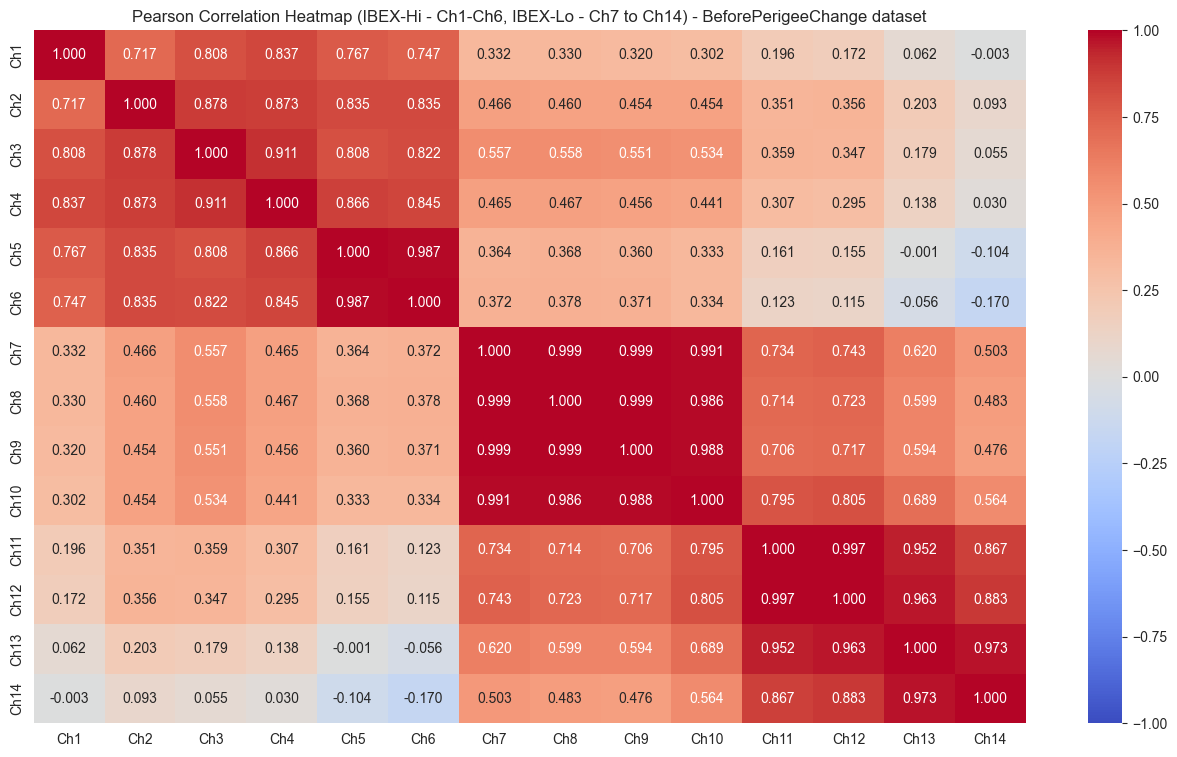

In [34]:
all_channels = []
lengths = []
for i in range(1, 15):  # 1..14
    counts, mid_times = load_data(
        f"channel_analyzer_out_old/BeforePerigeeChange/channel_{i}_good_data.txt"
    )
    grid_time, interpolated_counts, mvp = interpolate_trapezoid(counts, mid_times, 18)
    all_channels.append(interpolated_counts)
    lengths.append(counts.shape[0])

max_len = min(lengths)
print(max_len)
print(lengths)

all_channels = np.array(all_channels)
all_channels = all_channels.T
corr_matrix = np.corrcoef(all_channels, rowvar=False)
df_corr = pd.DataFrame(corr_matrix,
                       index=[f"Ch{i}" for i in range(1, 15)],
                       columns=[f"Ch{i}" for i in range(1, 15)])
plt.figure(figsize=(16, 9))
sns.heatmap(df_corr, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap (IBEX-Hi - Ch1-Ch6, IBEX-Lo - Ch7 to Ch14) - BeforePerigeeChange dataset")
plt.show()

186
[1526, 2837, 3492, 4424, 4766, 4291, 267, 186, 186, 186, 186, 200, 267, 267]


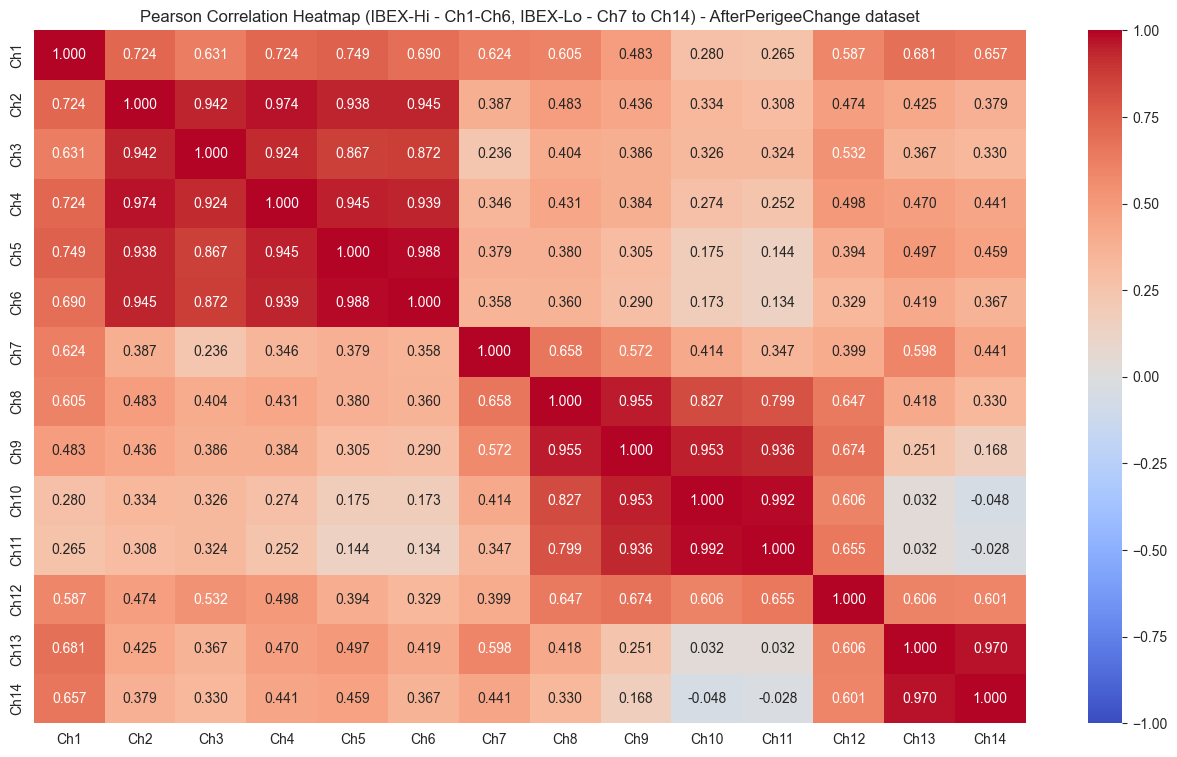

In [35]:
all_channels = []
lengths = []
for i in range(1, 15):  # 1..14
    counts, mid_times = load_data(
        f"channel_analyzer_out_old/AfterPerigeeChange/channel_{i}_good_data.txt"
    )
    grid_time, interpolated_counts, mvp = interpolate_trapezoid(counts, mid_times, 18)
    all_channels.append(interpolated_counts)
    lengths.append(counts.shape[0])

max_len = min(lengths)
print(max_len)
print(lengths)

all_channels = np.array(all_channels)
all_channels = all_channels.T
corr_matrix = np.corrcoef(all_channels, rowvar=False)
df_corr = pd.DataFrame(corr_matrix,
                       index=[f"Ch{i}" for i in range(1, 15)],
                       columns=[f"Ch{i}" for i in range(1, 15)])
plt.figure(figsize=(16, 9))
sns.heatmap(df_corr, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap (IBEX-Hi - Ch1-Ch6, IBEX-Lo - Ch7 to Ch14) - AfterPerigeeChange dataset")
plt.show()

Interpolated data shape: (536, 14)
X shape: (536, 13)
y shape: (536,)
==== MLP – INTERPOLATED COUNTS ====
TRAIN RMSE (scaled): 0.4857
TEST  RMSE (scaled): 0.6736


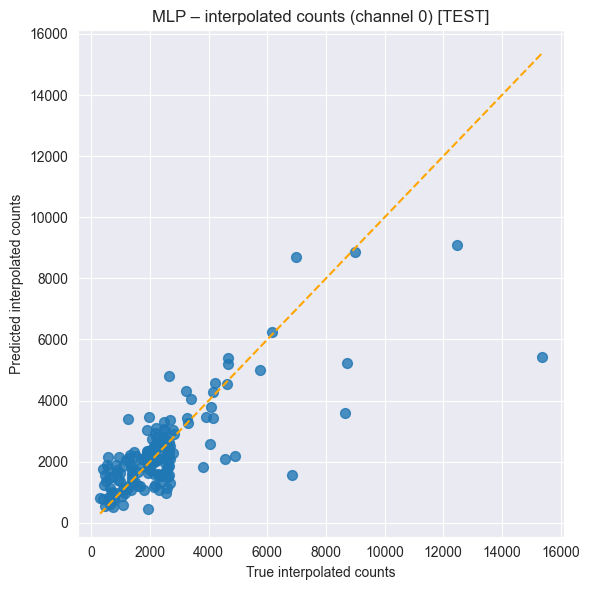

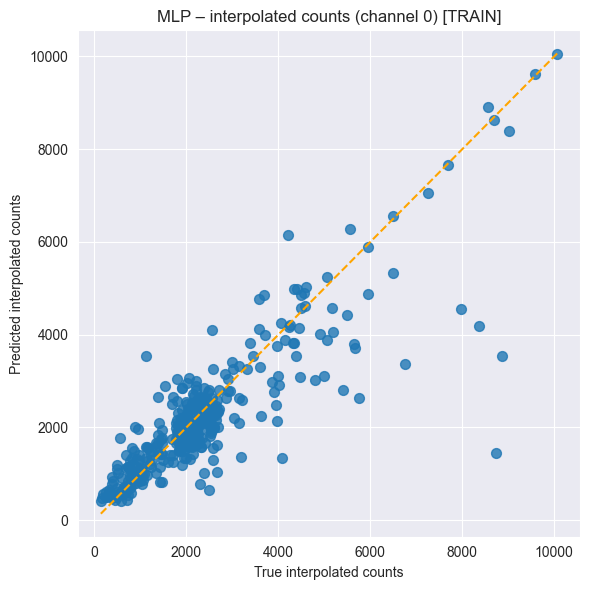

In [44]:
DATA_DIR = "channel_analyzer_out_old/AfterPerigeeChange"
TARGET_CHANNEL = 0
N_GRID = 100
RANDOM_STATE = 42
all_mid_times = []
for ch in range(1, 15):
    counts, mid_times = load_data(
        f"channel_analyzer_out_old/AfterPerigeeChange/channel_{ch}_good_data.txt"
    )
    all_mid_times.append(mid_times)
t_min = max(mt.min() for mt in all_mid_times)
t_max = min(mt.max() for mt in all_mid_times)
dts = []
for mt in all_mid_times:
    dts.append(np.median(np.diff(np.sort(mt))))

dt = np.median(dts)
N_GRID = int((t_max - t_min) / dt)
global_time_grid = np.linspace(t_min, t_max, N_GRID)
def interpolate_to_global_grid(counts, mid_times, global_grid):
    f = interp1d(
        mid_times,
        counts,
        kind="linear",
        bounds_error=False,
        fill_value="extrapolate"
    )
    return f(global_grid)
all_channels = []

for ch in range(1, 15):
    counts, mid_times = load_data(
        f"channel_analyzer_out_old/AfterPerigeeChange/channel_{ch}_good_data.txt"
    )
    interp_counts = interpolate_to_global_grid(
        counts, mid_times, global_time_grid
    )
    all_channels.append(interp_counts)

all_channels = np.array(all_channels).T
print("Interpolated data shape:", all_channels.shape)
X = np.delete(all_channels, TARGET_CHANNEL, axis=1)
y = np.log1p(all_channels[:, TARGET_CHANNEL])

print("X shape:", X.shape)
print("y shape:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test  = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=3e-4,
    alpha=1e-4,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=50,
    validation_fraction=0.2,
    random_state=RANDOM_STATE
)


mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred  = mlp.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("==== MLP – INTERPOLATED COUNTS ====")
print(f"TRAIN RMSE (scaled): {rmse_train:.4f}")
print(f"TEST  RMSE (scaled): {rmse_test:.4f}")
y_train_true = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()

y_test_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
y_train_true = np.expm1(y_train_true)
y_train_pred  = np.expm1(y_train_pred )
y_test_true = np.expm1(y_test_true)
y_test_pred = np.expm1(y_test_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_true, y_test_pred, s=50, alpha=0.8)

lims = [
    min(y_test_true.min(), y_test_pred.min()),
    max(y_test_true.max(), y_test_pred.max())
]
plt.plot(lims, lims, "--", color="orange")

plt.xlabel("True interpolated counts")
plt.ylabel("Predicted interpolated counts")
plt.title(f"MLP – interpolated counts (channel {TARGET_CHANNEL}) [TEST]")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred, s=50, alpha=0.8)

lims = [
    min(y_train_true.min(), y_train_pred.min()),
    max(y_train_true.max(), y_train_pred.max())
]
plt.plot(lims, lims, "--", color="orange")

plt.xlabel("True interpolated counts")
plt.ylabel("Predicted interpolated counts")
plt.title(f"MLP – interpolated counts (channel {TARGET_CHANNEL}) [TRAIN]")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
def plot_pred_vs_true(y_true, y_pred, title, filename, label_x='Reference values', label_y='Predicted values', margin=0.03):
    plt.figure(figsize=(16, 9))
    plt.scatter(y_true, y_pred, s=5, alpha=0.4)
    x_min, x_max = y_true.min(), y_true.max()
    y_min, y_max = y_pred.min(), y_pred.max()
    dx = x_max - x_min
    dy = y_max - y_min
    plt.xlim(x_min - margin * dx, x_max + margin * dx)
    plt.ylim(y_min - margin * dy, y_max + margin * dy)
    xx = np.linspace(x_min, x_max, 200)
    plt.plot(xx, xx, '--', color='red', linewidth=2, label='Ideal prediction (y = x)')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


In [41]:
def plot_loss_curves(model, out_path):
    plt.figure(figsize=(10, 6))
    plt.plot(
        model.loss_curve_,
        label="Training loss (MSE)",
        color="blue"
    )
    if hasattr(model, "validation_scores_"):
        plt.plot(
            model.validation_scores_,
            label="Validation score (R²)",
            color="orange"
        )
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Score")
    plt.title("MLPRegressor training")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

In [40]:
def load_datasets(DATA_DIR, TARGET_CHANNEL, test_size=0.2):
    FEATURE_IDXS = [
        0,      # sum
        4,      # rate
        5, 6, 7,
        8, 9, 10,
        11, 12, 13,
        14, 15, 16,
        17, 18
    ] #skipped indexes are just metadata not crucial to this process
    channel_data = {}
    lengths = []
    for ch in range(1, 15):
        path = os.path.join(DATA_DIR, f"channel_{ch}_good_data_aggregated.txt")
        data = np.loadtxt(path, skiprows=1)
        channel_data[ch] = data
        lengths.append(len(data))

    min_len = min(lengths)
    print("Using common length:", min_len)
    X_list = []
    y_list = []

    for i in range(min_len):
        x_row = []
        for ch in range(1, 15):
            features = channel_data[ch][i, FEATURE_IDXS]
            if ch == TARGET_CHANNEL:
                y_row = features
            else:
                x_row.extend(features)
        X_list.append(x_row)
        y_list.append(y_row)

    X = np.array(X_list)
    y = np.array(y_list)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train)
    y_test  = scaler_y.transform(y_test)

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

In [51]:
def print_and_save_metrics(TARGET_CHANNEL, output_path, y_test, y_train, y_test_pred, y_train_pred, scaler_y):
    # SCALED METRICS
    rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test   = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train  = mean_absolute_error(y_train, y_train_pred)

    std_test  = np.std(y_test)
    std_train = np.std(y_train)

    rmse_std_test  = rmse_test / std_test if std_test > 0 else np.inf
    rmse_std_train = rmse_train / std_train if std_train > 0 else np.inf

    # INVERSE SCALING
    y_train_true_phys = scaler_y.inverse_transform(y_train)
    y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
    y_test_true_phys  = scaler_y.inverse_transform(y_test)
    y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)

    # PHYSICAL METRICS
    rmse_phys_test  = np.sqrt(mean_squared_error(y_test_true_phys, y_test_pred_phys))
    mae_phys_test   = mean_absolute_error(y_test_true_phys, y_test_pred_phys)
    rmse_phys_train = np.sqrt(mean_squared_error(y_train_true_phys, y_train_pred_phys))
    mae_phys_train  = mean_absolute_error(y_train_true_phys, y_train_pred_phys)

    std_phys_test  = np.std(y_test_true_phys)
    std_phys_train = np.std(y_train_true_phys)

    rmse_std_phys_test  = rmse_phys_test / std_phys_test if std_phys_test > 0 else np.inf
    rmse_std_phys_train = rmse_phys_train / std_phys_train if std_phys_train > 0 else np.inf

    # RESULTS -- SUMMARY
    results_text = (
        f"############# TARGET CHANNEL = {TARGET_CHANNEL} #############\n"
        f"==== TRAINING ====\n"
        f"RMSE (global): {rmse_train:.4f}\n"
        f"MAE  (global): {mae_train:.4f}\n"
        f"RMSE/STD (global): {rmse_std_train:.4f}\n"
        f"RMSE (physical units): {rmse_phys_train:.4f}\n"
        f"MAE  (physical units): {mae_phys_train:.4f}\n"
        f"RMSE/STD (physical units): {rmse_std_phys_train:.4f}\n"
        f"==== TEST ====\n"
        f"RMSE (global): {rmse_test:.4f}\n"
        f"MAE  (global): {mae_test:.4f}\n"
        f"RMSE/STD (global): {rmse_std_test:.4f}\n"
        f"RMSE (physical units): {rmse_phys_test:.4f}\n"
        f"MAE  (physical units): {mae_phys_test:.4f}\n"
        f"RMSE/STD (physical units): {rmse_std_phys_test:.4f}\n"
    )
    print(results_text)
    output_file = os.path.join(output_path, f"test_and_training_metrics.txt")
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(results_text)


In [62]:
def generate_and_save_training_and_test_plot_sets(TARGET_CHANNEL, output_path, FEATURE_NAMES, scaler_y, y_test, y_train, y_test_pred, y_train_pred):
    y_train_true_phys = scaler_y.inverse_transform(y_train)
    y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
    y_test_true_phys  = scaler_y.inverse_transform(y_test)
    y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)
    if TARGET_CHANNEL <= 6:
        channel_dir = f"Hi_{TARGET_CHANNEL}"
    else:
        channel_dir = f"Lo_{TARGET_CHANNEL}"
    save_dir = os.path.join(output_path, channel_dir)
    os.makedirs(save_dir, exist_ok=True)
    #trainig plots
    fig, axes = plt.subplots(4, 4, figsize=(18, 16))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
        ax.scatter(y_train_true_phys[:, i], y_train_pred_phys[:, i], s=8, alpha=0.5)
        lims = [min(y_train_true_phys[:, i].min(), y_train_pred_phys[:, i].min()), max(y_train_true_phys[:, i].max(), y_train_pred_phys[:, i].max())]
        ax.plot(lims, lims, "--", color="orange")
        ax.set_title(FEATURE_NAMES[i])
        ax.grid(True)

    plt.suptitle(f"y_pred vs y_true (TRAIN) – channel {TARGET_CHANNEL}", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"training_plot_set_channel_{TARGET_CHANNEL}.png"))
    # plt.show()
    plt.close()
    # test plots
    fig, axes = plt.subplots(4, 4, figsize=(18, 16))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
        ax.scatter(y_test_true_phys[:, i], y_test_pred_phys[:, i], s=8, alpha=0.5)
        lims = [min(y_test_true_phys[:, i].min(), y_test_pred_phys[:, i].min()), max(y_test_true_phys[:, i].max(), y_test_pred_phys[:, i].max())]
        ax.plot(lims, lims, "--", color="orange")
        ax.set_title(FEATURE_NAMES[i])
        ax.grid(True)

    plt.suptitle(f"y_pred vs y_true (TEST) – channel {TARGET_CHANNEL}", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"test_plot_set_channel_{TARGET_CHANNEL}.png"))
    # plt.show()
    plt.close()


In [63]:
save_path = "rzeczy do inż/MLPRegressor/AfterPerigeeChange"
for i in range(1, 15):
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_datasets("channel_analyzer_out_aggregated/AfterPerigeeChange", i)

    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=5000,
        random_state=42,
        tol=1e-6
    )

    mlp.fit(X_train, y_train)
    y_train_pred = mlp.predict(X_train)
    y_test_pred  = mlp.predict(X_test)

    print_and_save_metrics(i, save_path, y_test, y_train, y_test_pred, y_train_pred, scaler_y)

    y_train_true_phys = scaler_y.inverse_transform(y_train)
    y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
    y_test_true_phys  = scaler_y.inverse_transform(y_test)
    y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)

    FEATURE_NAMES = ["sum", "rate", "cos_RA", "sin_RA", "R_RA", "cos_phase", "sin_phase", "R_phase", "mean_X", "mean_Y", "mean_Z", "std_X", "std_Y", "std_Z","mean_R", "std_R"]
    generate_and_save_training_and_test_plot_sets(i, save_path, FEATURE_NAMES, scaler_y, y_test, y_train, y_test_pred, y_train_pred)
    if i <= 6:
        channel_dir = f"Hi_{i}"
    else:
        channel_dir = f"Lo_{i}"
    #Training loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(mlp.loss_curve_, label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MLP training loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    save_dir = os.path.join(save_path, channel_dir)
    plt.savefig(os.path.join(save_dir,f"loss_curve_channel_{i}.png"))
    # plt.show()
    plt.close()

Using common length: 186
X shape: (186, 208)
y shape: (186, 16)
############# TARGET CHANNEL = 1 #############
==== TRAINING ====
RMSE (global): 0.0321
MAE  (global): 0.0200
RMSE/STD (global): 0.0321
RMSE (physical units): 16.9251
MAE  (physical units): 2.8604
RMSE/STD (physical units): 0.0302
==== TEST ====
RMSE (global): 1.1850
MAE  (global): 0.9348
RMSE/STD (global): 1.1226
RMSE (physical units): 420.2234
MAE  (physical units): 80.2688
RMSE/STD (physical units): 0.8037

Using common length: 186
X shape: (186, 208)
y shape: (186, 16)
############# TARGET CHANNEL = 2 #############
==== TRAINING ====
RMSE (global): 0.0363
MAE  (global): 0.0201
RMSE/STD (global): 0.0363
RMSE (physical units): 13.8665
MAE  (physical units): 2.6524
RMSE/STD (physical units): 0.0279
==== TEST ====
RMSE (global): 1.2020
MAE  (global): 0.8915
RMSE/STD (global): 0.9955
RMSE (physical units): 380.7520
MAE  (physical units): 69.2718
RMSE/STD (physical units): 0.7196

Using common length: 186
X shape: (186, 208)

In [64]:
save_path = "rzeczy do inż/MLPRegressor/BeforePerigeeChange"
for i in range(1, 15):
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_datasets("channel_analyzer_out_aggregated/BeforePerigeeChange", i)

    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=5000,
        random_state=42,
        tol=1e-6
    )

    mlp.fit(X_train, y_train)
    y_train_pred = mlp.predict(X_train)
    y_test_pred  = mlp.predict(X_test)

    print_and_save_metrics(i, save_path, y_test, y_train, y_test_pred, y_train_pred, scaler_y)

    y_train_true_phys = scaler_y.inverse_transform(y_train)
    y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
    y_test_true_phys  = scaler_y.inverse_transform(y_test)
    y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)

    FEATURE_NAMES = ["sum", "rate", "cos_RA", "sin_RA", "R_RA", "cos_phase", "sin_phase", "R_phase", "mean_X", "mean_Y", "mean_Z", "std_X", "std_Y", "std_Z","mean_R", "std_R"]
    generate_and_save_training_and_test_plot_sets(i, save_path, FEATURE_NAMES, scaler_y, y_test, y_train, y_test_pred, y_train_pred)
    if i <= 6:
        channel_dir = f"Hi_{i}"
    else:
        channel_dir = f"Lo_{i}"
    # --- Training loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(mlp.loss_curve_, label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MLP training loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    save_dir = os.path.join(save_path, channel_dir)
    plt.savefig(os.path.join(save_dir,f"loss_curve_channel_{i}.png"))
    # plt.show()
    plt.close()

Using common length: 62
X shape: (62, 208)
y shape: (62, 16)
############# TARGET CHANNEL = 1 #############
==== TRAINING ====
RMSE (global): 0.0174
MAE  (global): 0.0116
RMSE/STD (global): 0.0174
RMSE (physical units): 11.9200
MAE  (physical units): 1.8834
RMSE/STD (physical units): 0.0098
==== TEST ====
RMSE (global): 1.8874
MAE  (global): 1.2797
RMSE/STD (global): 1.1656
RMSE (physical units): 1584.2347
MAE  (physical units): 306.4430
RMSE/STD (physical units): 0.8275

Using common length: 62
X shape: (62, 208)
y shape: (62, 16)
############# TARGET CHANNEL = 2 #############
==== TRAINING ====
RMSE (global): 0.0214
MAE  (global): 0.0141
RMSE/STD (global): 0.0214
RMSE (physical units): 14.9469
MAE  (physical units): 2.2660
RMSE/STD (physical units): 0.0107
==== TEST ====
RMSE (global): 1.5968
MAE  (global): 1.2459
RMSE/STD (global): 1.3713
RMSE (physical units): 1085.1249
MAE  (physical units): 233.5763
RMSE/STD (physical units): 1.2767

Using common length: 62
X shape: (62, 208)
y s

In [5]:
def plot_rate_histograms(rates, title_prefix):
    n_ch = rates.shape[1]
    fig, axes = plt.subplots(4, 4, figsize=(16, 14))
    axes = axes.flatten()

    for ch in range(n_ch):
        axes[ch].hist(rates[:, ch], bins=50, alpha=0.7)
        axes[ch].set_title(f"Channel {ch+1}")
        axes[ch].set_xlabel("Rate")
        axes[ch].set_ylabel("Counts")

    for ax in axes[n_ch:]:
        ax.axis("off")

    fig.suptitle(title_prefix, fontsize=16)
    plt.tight_layout()
    plt.show()

In [4]:
def load_dataset(base_dir):
    base_dir = Path(base_dir)
    rates = np.load(base_dir / "rates.npy")
    conds = np.load(base_dir / "conditions.npy")
    return rates, conds

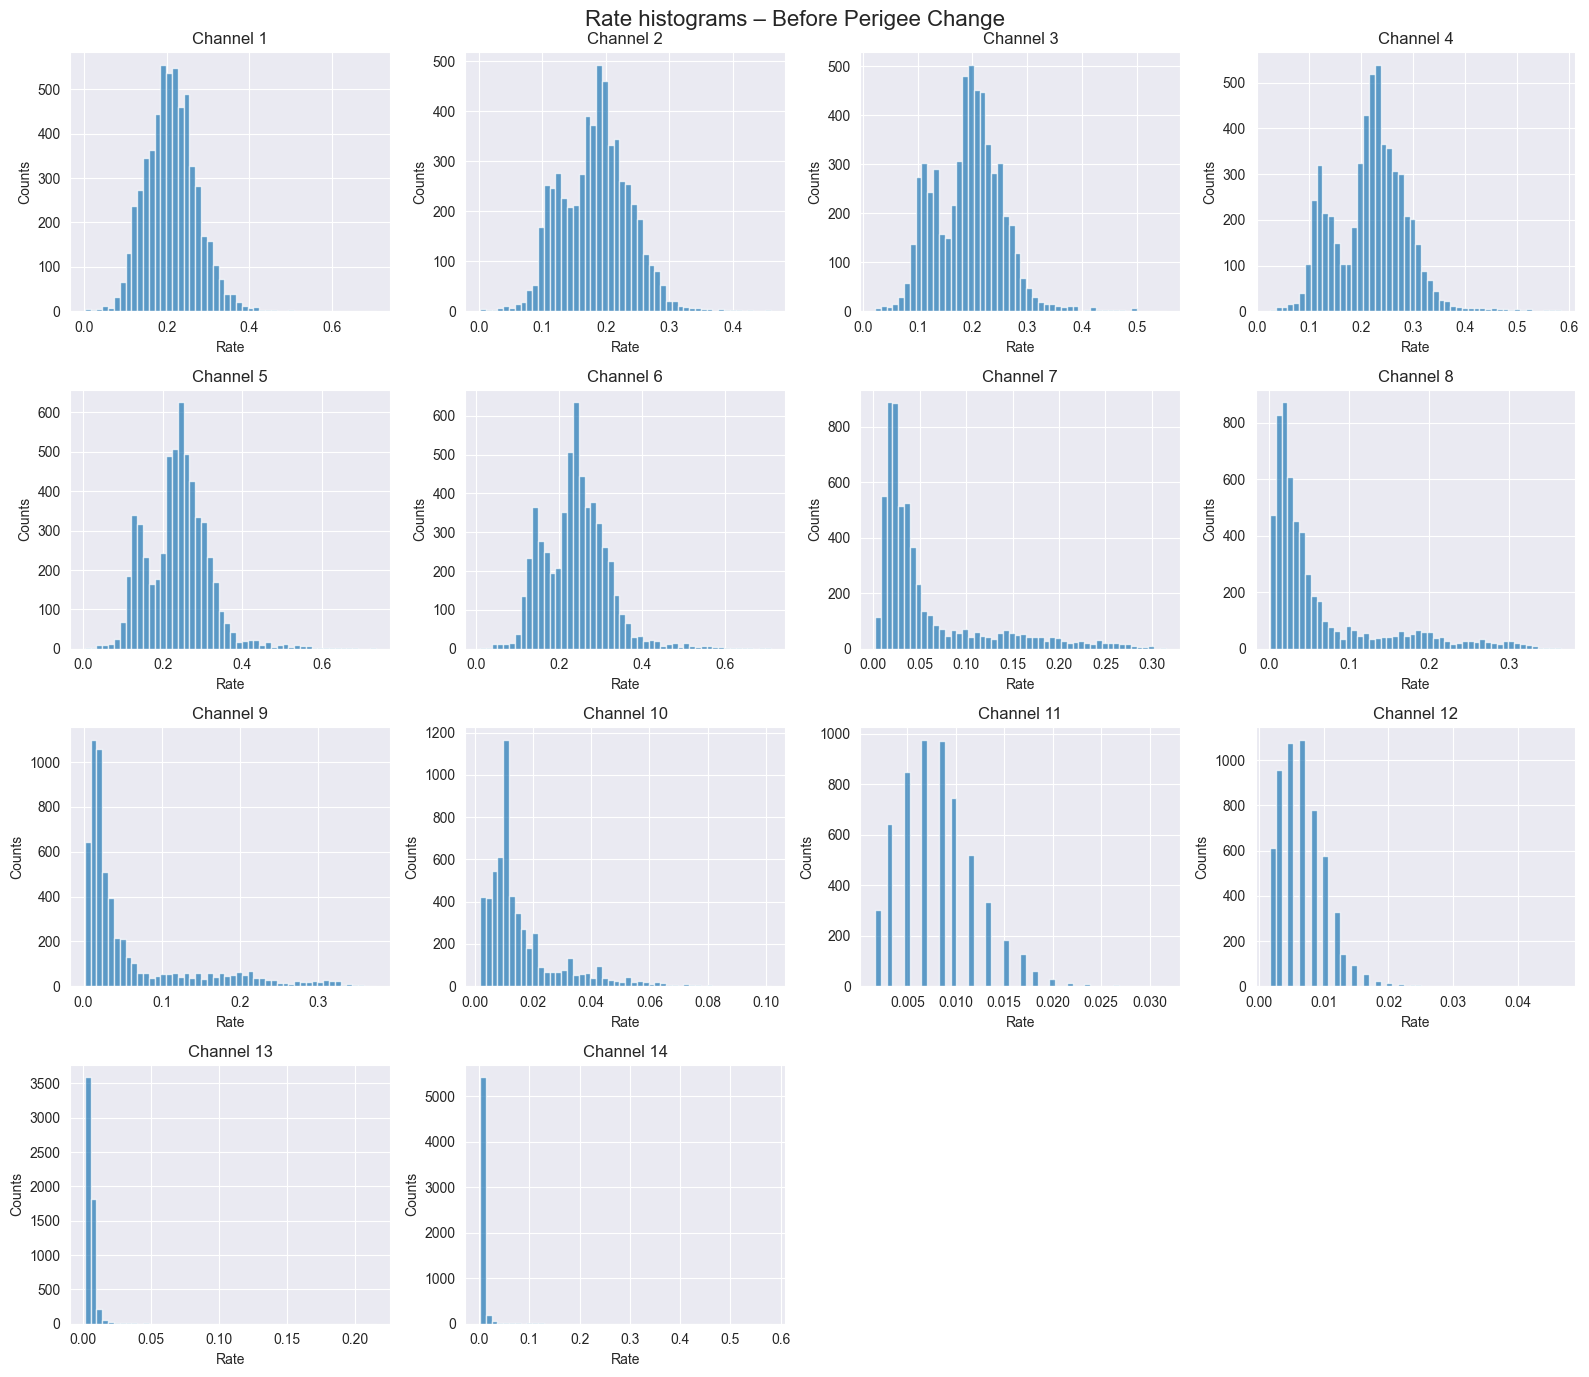

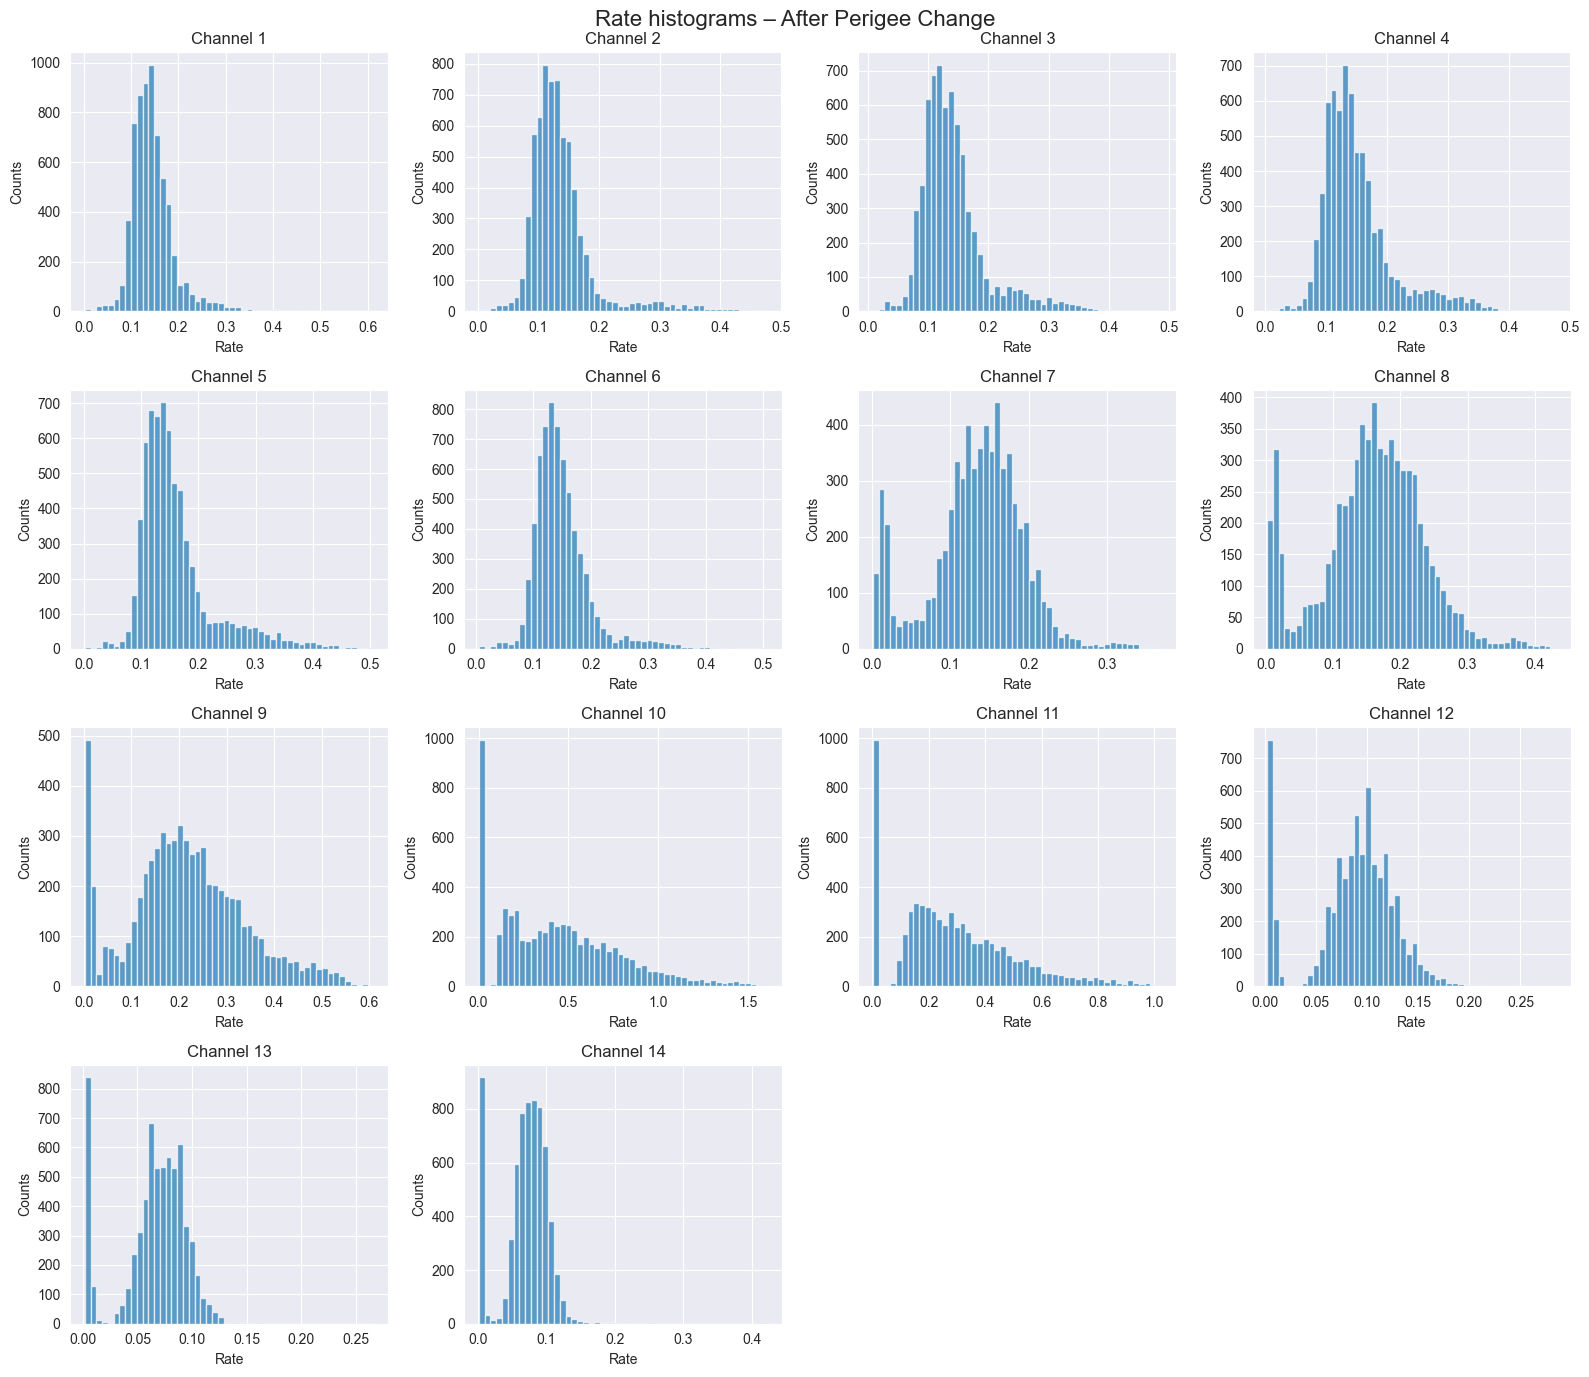

In [6]:
rates_before, conds_before = load_dataset(
    "aggregated_data_for_autoencoder/BeforePerigeeChange"
)
rates_after, conds_after = load_dataset(
    "aggregated_data_for_autoencoder/AfterPerigeeChange"
)
plot_rate_histograms(rates_before, "Rate histograms – Before Perigee Change")
plot_rate_histograms(rates_after,  "Rate histograms – After Perigee Change")

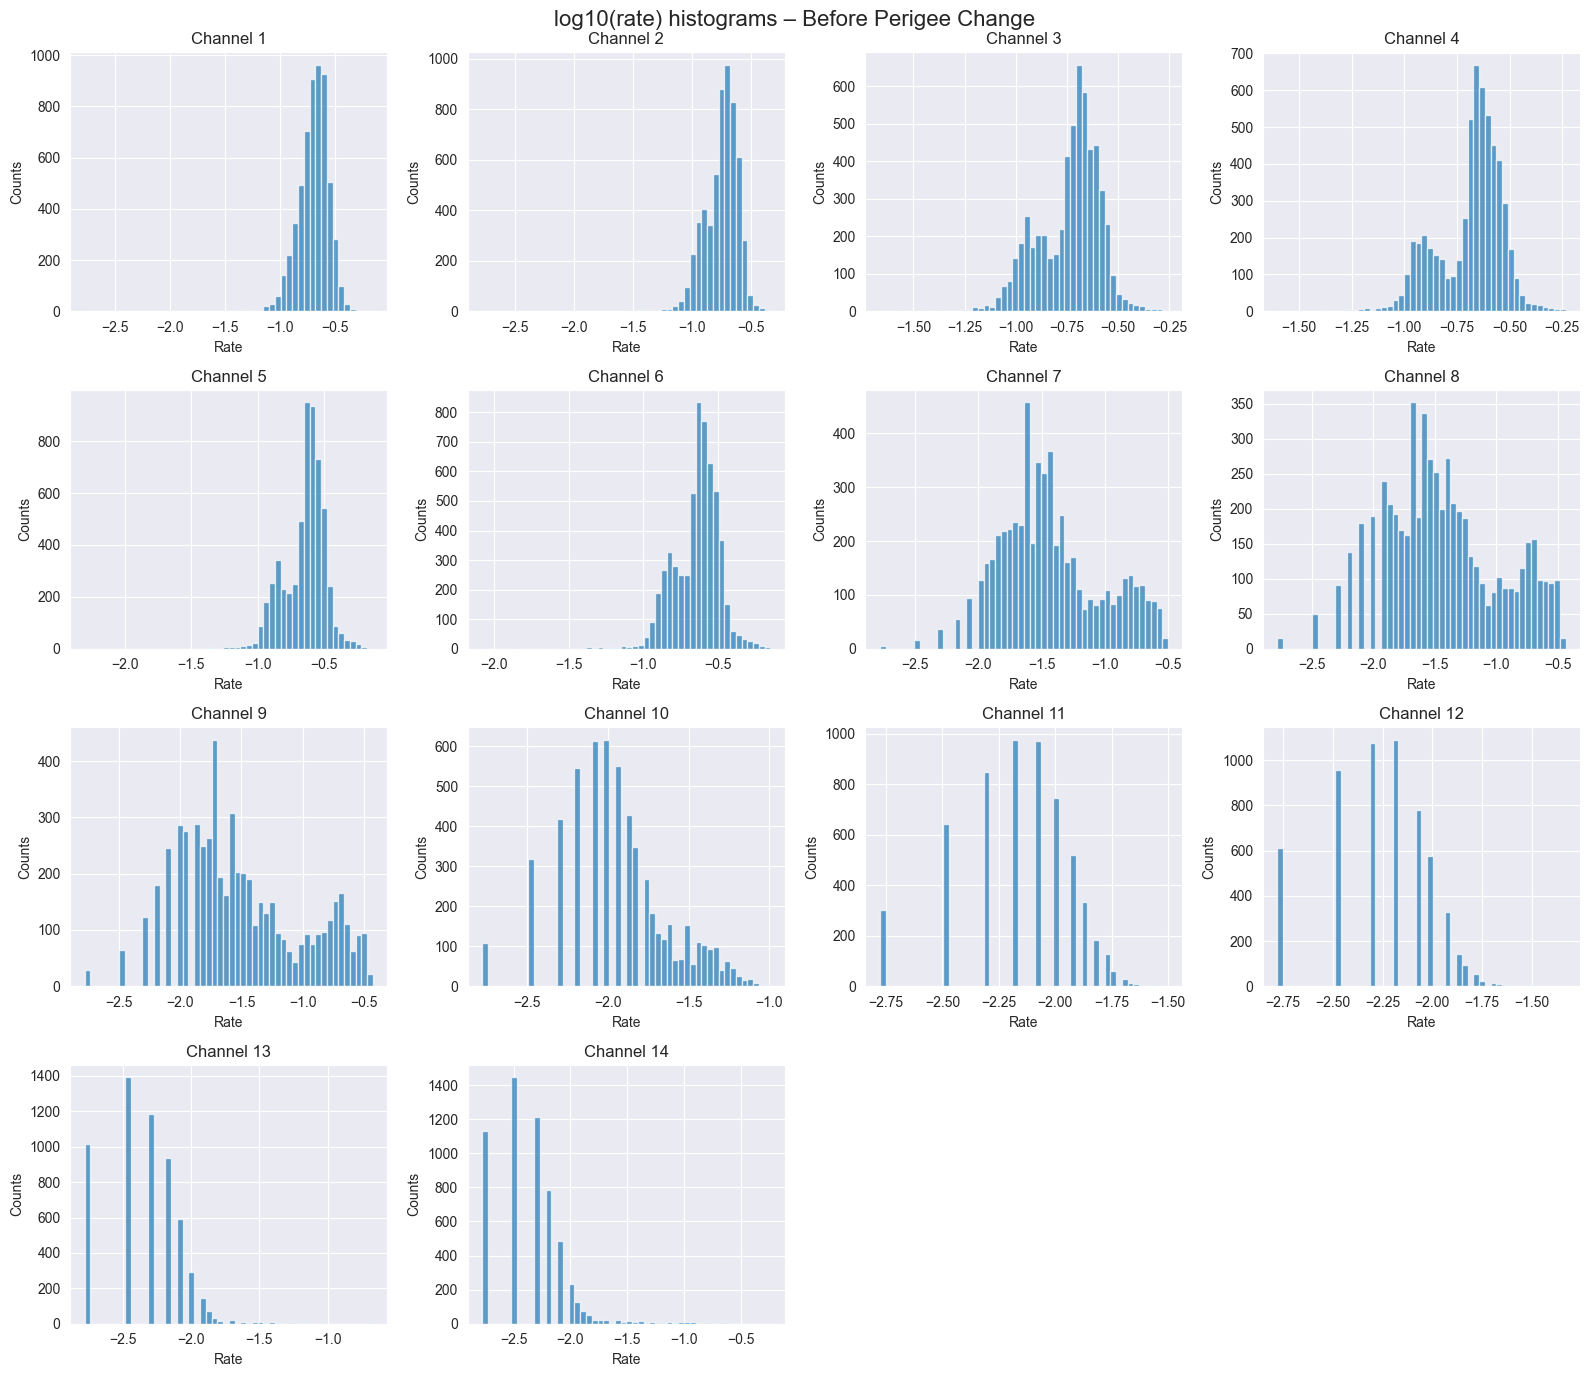

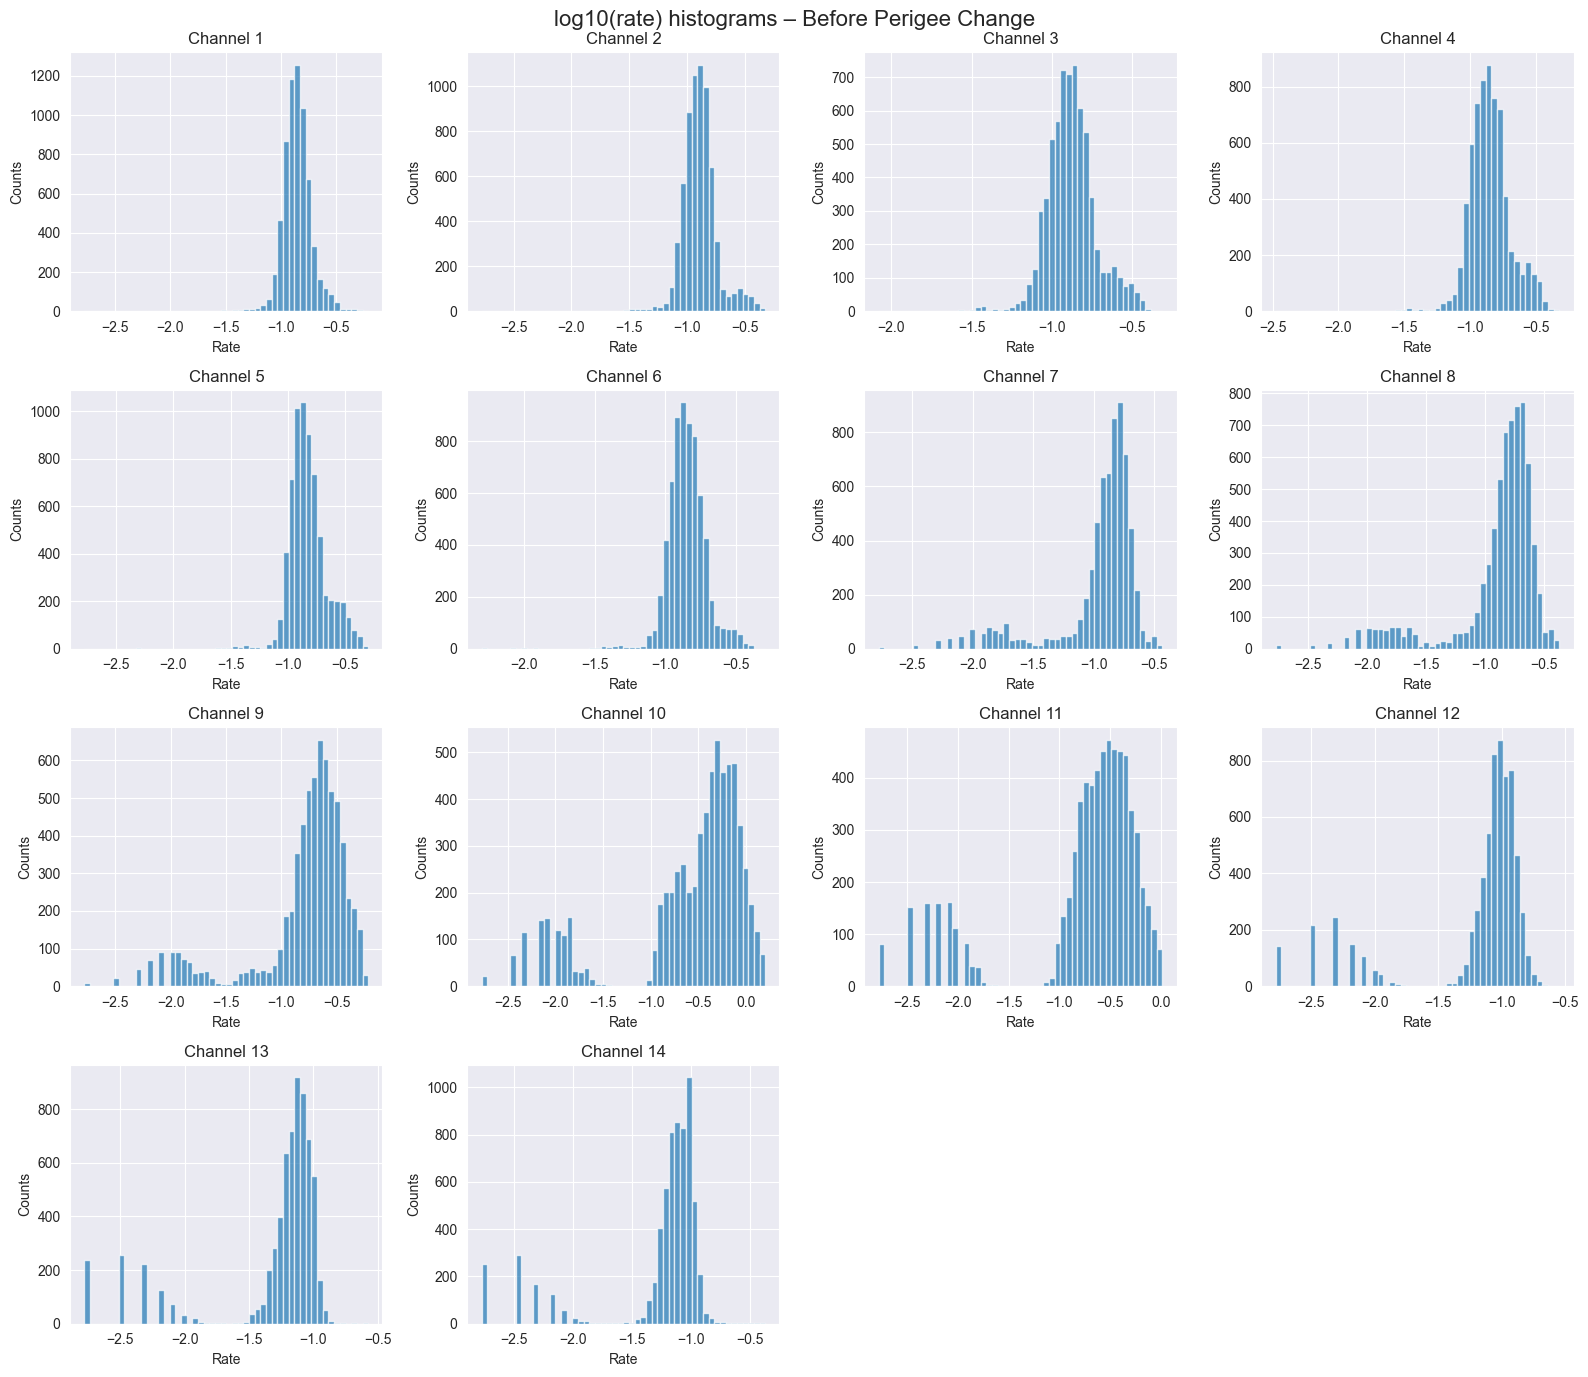

In [7]:
rates_before, conds_before = load_dataset(
    "aggregated_data_for_autoencoder/BeforePerigeeChange"
)
rates_after, conds_after = load_dataset(
    "aggregated_data_for_autoencoder/AfterPerigeeChange"
)
plot_rate_histograms(
    np.log10(rates_before + 1e-6),
    "log10(rate) histograms – Before Perigee Change"
)

plot_rate_histograms(
    np.log10(rates_after + 1e-6),
    "log10(rate) histograms – Before Perigee Change"
)


In [10]:
def plot_correlation_matrix(rates, title, channel_labels=None):
    """
    rates : np.ndarray (N, n_channels)
    """

    corr = np.corrcoef(rates.T)

    if channel_labels is None:
        channel_labels = [f"Ch {i+1}" for i in range(rates.shape[1])]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        vmin=-1,
        vmax=1,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        xticklabels=channel_labels,
        yticklabels=channel_labels,
        square=True,
        cbar_kws={"label": "Pearson r"}
    )

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [15]:
def standardize(X):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    return Xs, scaler

In [14]:
def run_pca(X):
    pca = PCA()
    Z = pca.fit_transform(X)
    return pca, Z

In [16]:
def plot_explained_variance(pca, title):
    cum = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 4))
    plt.plot(cum, marker="o")
    plt.axhline(0.9, linestyle="--", color="gray", label="90%")
    plt.axhline(0.8, linestyle="--", color="lightgray", label="80%")
    plt.xlabel("Number of principal components")
    plt.ylabel("Cumulative explained variance")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
def plot_loadings(pca, pc_idx, title):
    loadings = pca.components_[pc_idx]

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(loadings)+1), loadings)
    plt.xlabel("Channel")
    plt.ylabel("Loading")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_projection(Z, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(Z[:, 0], Z[:, 1], s=5, alpha=0.4)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

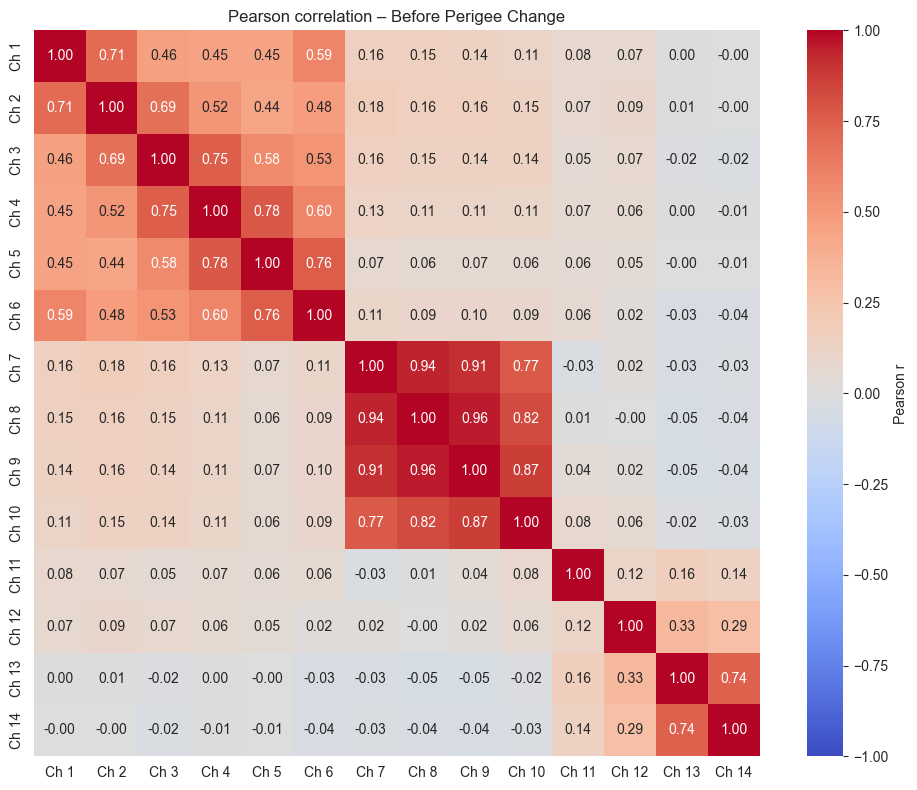

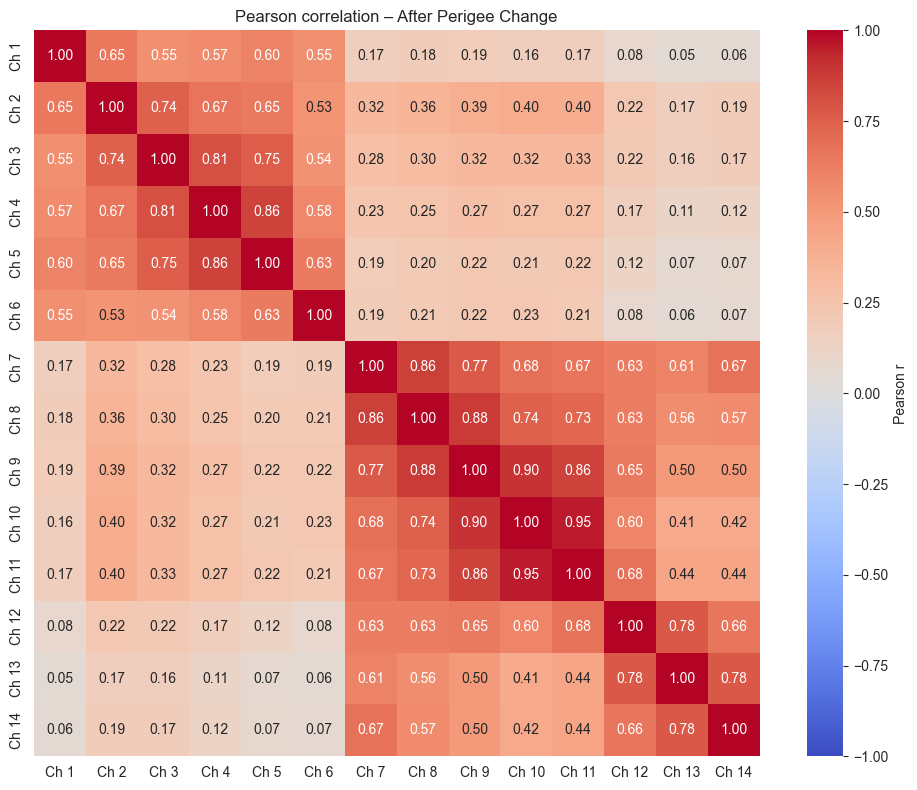

In [11]:
plot_correlation_matrix(
    rates_before,
    "Pearson correlation – Before Perigee Change"
)

plot_correlation_matrix(
    rates_after,
    "Pearson correlation – After Perigee Change"
)

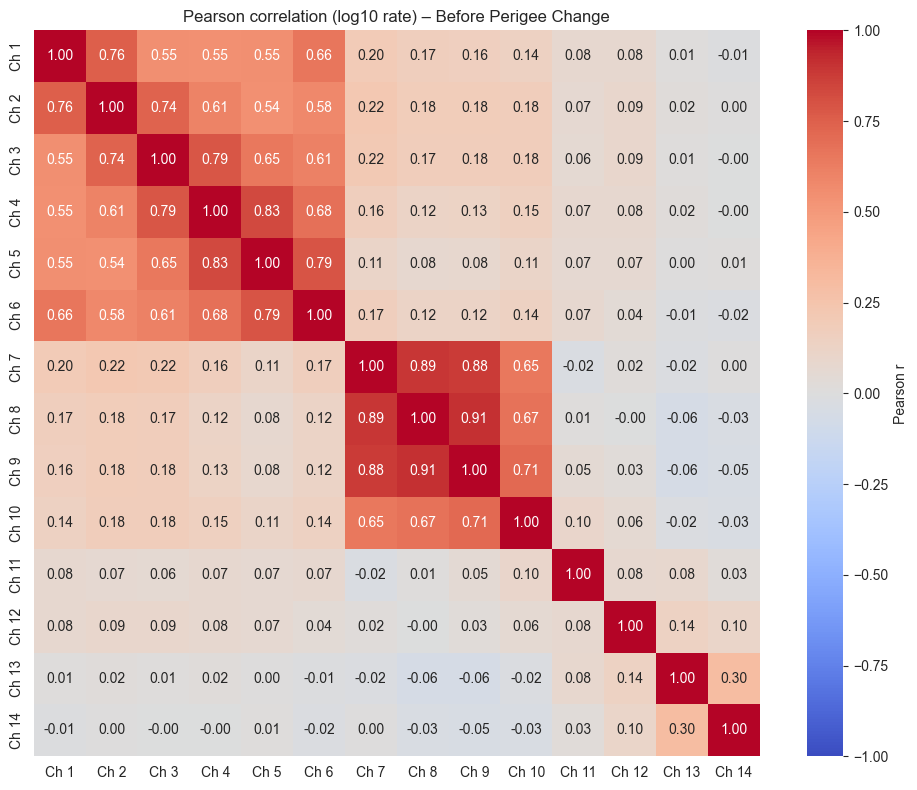

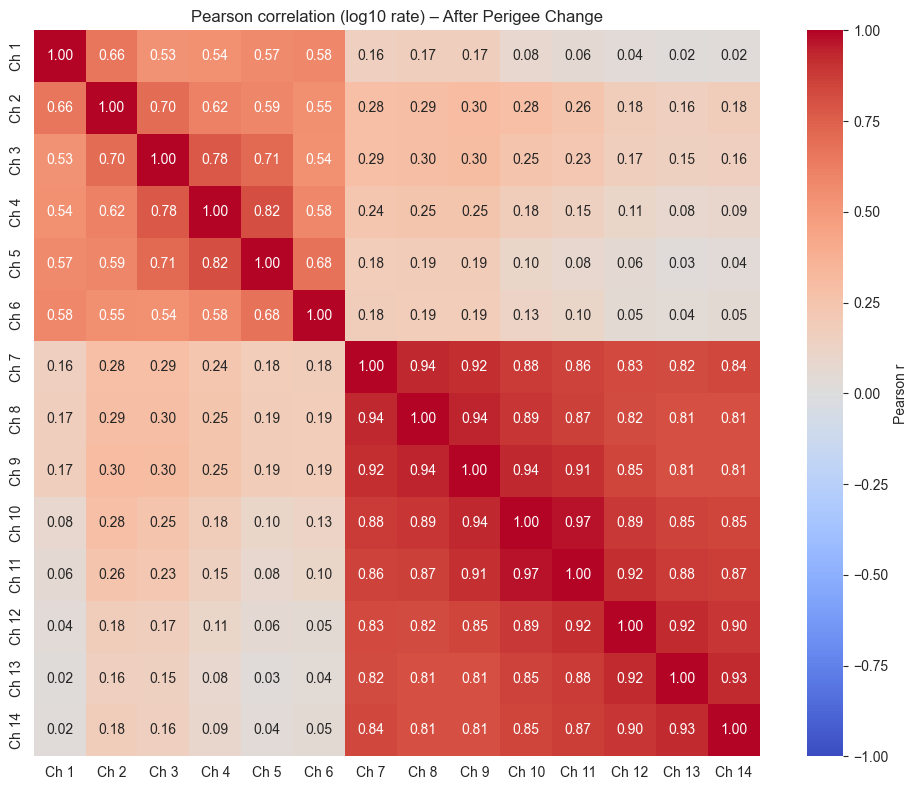

In [13]:
rates_before_log = np.log10(rates_before + 1e-6)
rates_after_log = np.log10(rates_after + 1e-6)
plot_correlation_matrix(
    rates_before_log,
    "Pearson correlation (log10 rate) – Before Perigee Change"
)
plot_correlation_matrix(
    rates_after_log,
    "Pearson correlation (log10 rate) – After Perigee Change"
)

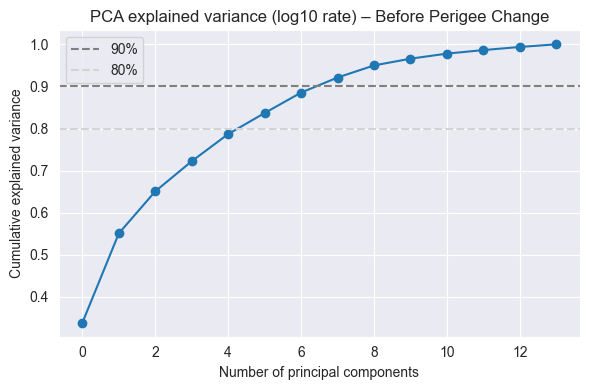

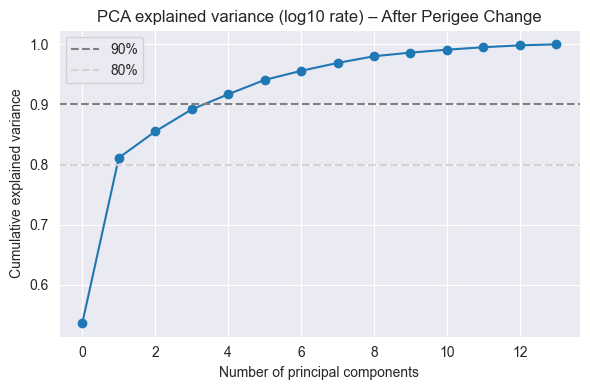

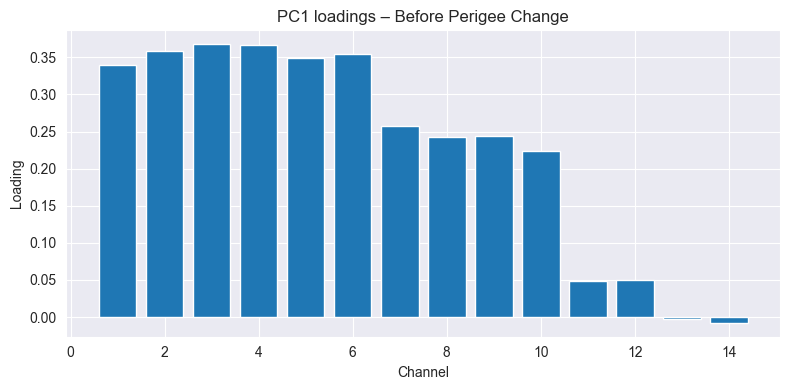

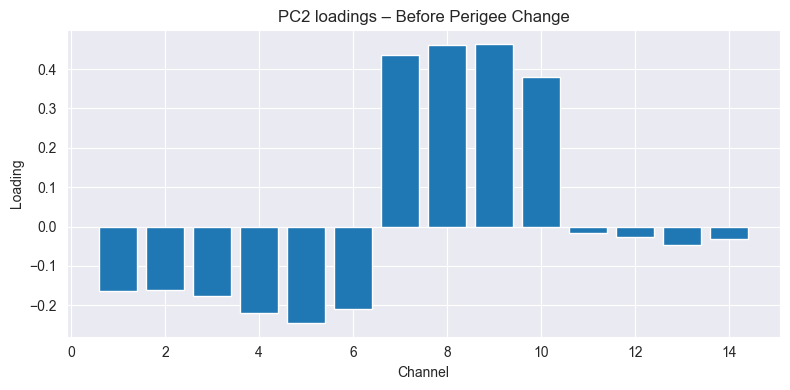

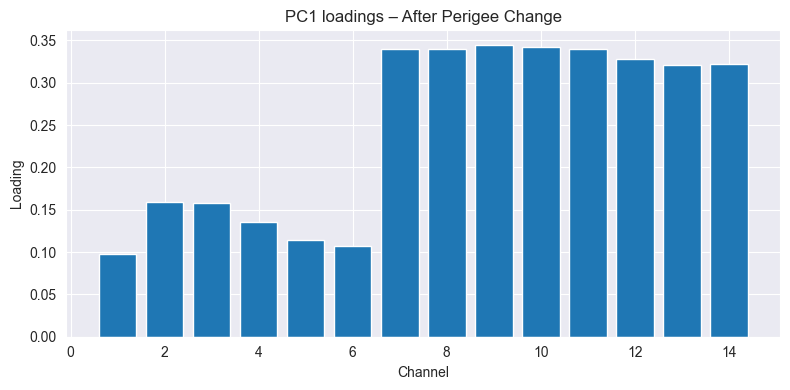

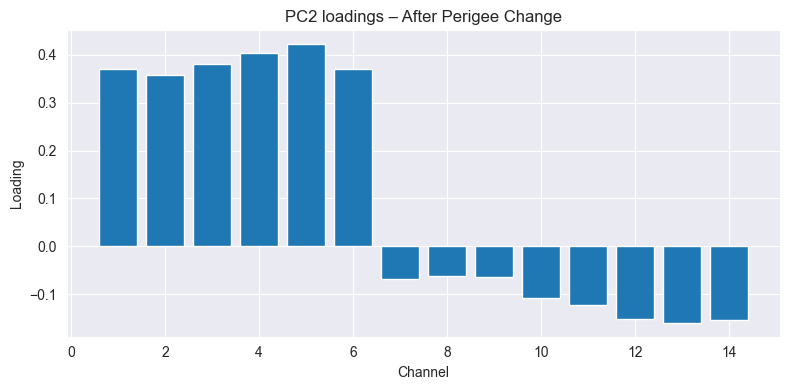

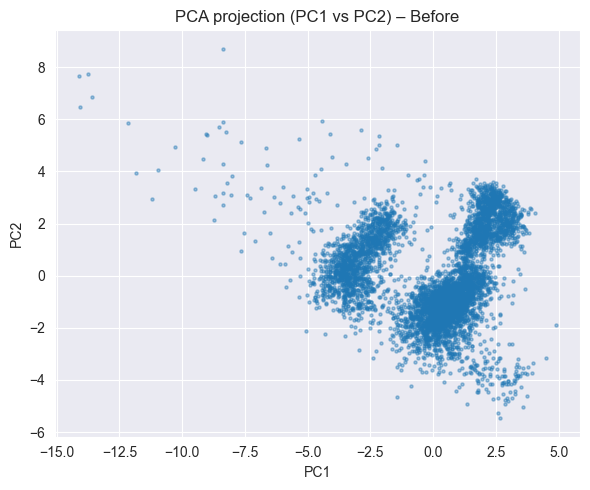

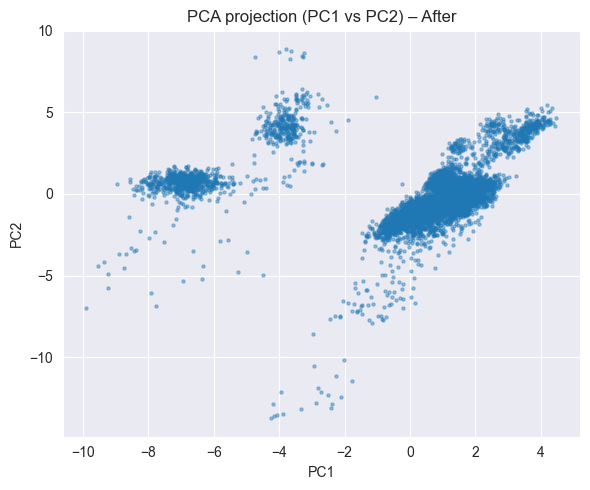

In [23]:
rates_before, _ = load_dataset("aggregated_data_for_autoencoder/BeforePerigeeChange")
rates_after, _ = load_dataset("aggregated_data_for_autoencoder/AfterPerigeeChange")
rates_before_log = np.log10(rates_before + 1e-6)
rates_after_log = np.log10(rates_after + 1e-6)
Xb, scaler_b = standardize(rates_before_log)
Xa, scaler_a = standardize(rates_after_log)
pca = PCA()
pca_before, Z_before = run_pca(Xb)
pca_after,  Z_after  = run_pca(Xa)
plot_explained_variance(pca_before, "PCA explained variance (log10 rate) – Before Perigee Change")
plot_explained_variance(pca_after, "PCA explained variance (log10 rate) – After Perigee Change")
plot_loadings(pca_before, 0, "PC1 loadings – Before Perigee Change")
plot_loadings(pca_before, 1, "PC2 loadings – Before Perigee Change")
plot_loadings(pca_after, 0, "PC1 loadings – After Perigee Change")
plot_loadings(pca_after, 1, "PC2 loadings – After Perigee Change")
plot_projection(Z_before, "PCA projection (PC1 vs PC2) – Before")
plot_projection(Z_after,  "PCA projection (PC1 vs PC2) – After")

Dane HI-6 (rate): (186, 14)
wyniki dla HI-6
RMSE=0.03186950133569144
MAE=0.026175975799866448
R²=-1.726654054814429
RMSE/STD=1.651258324676799


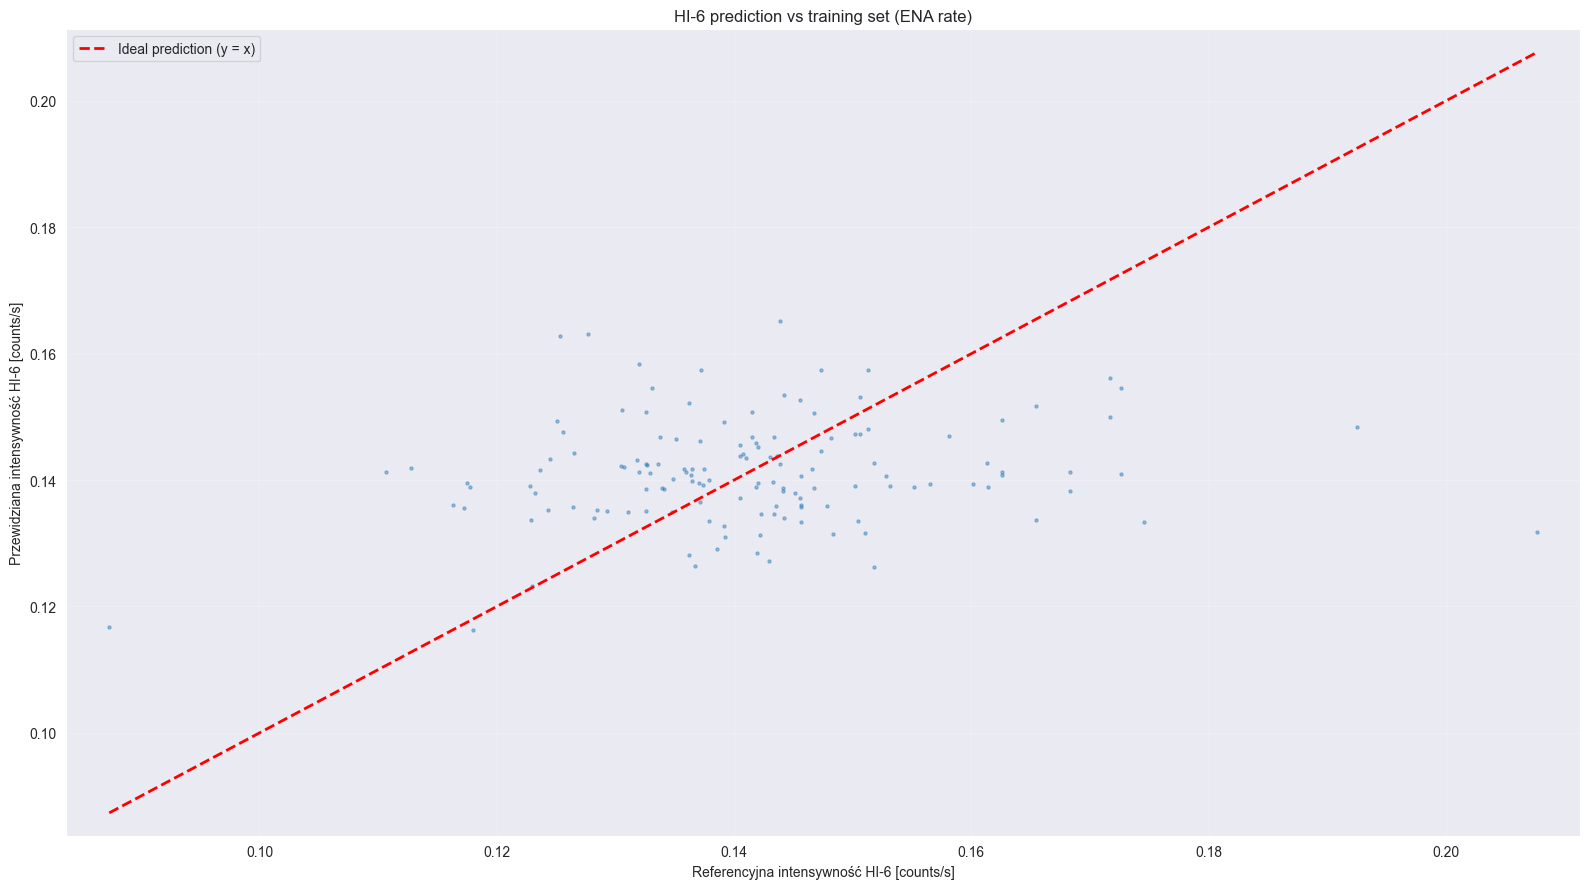

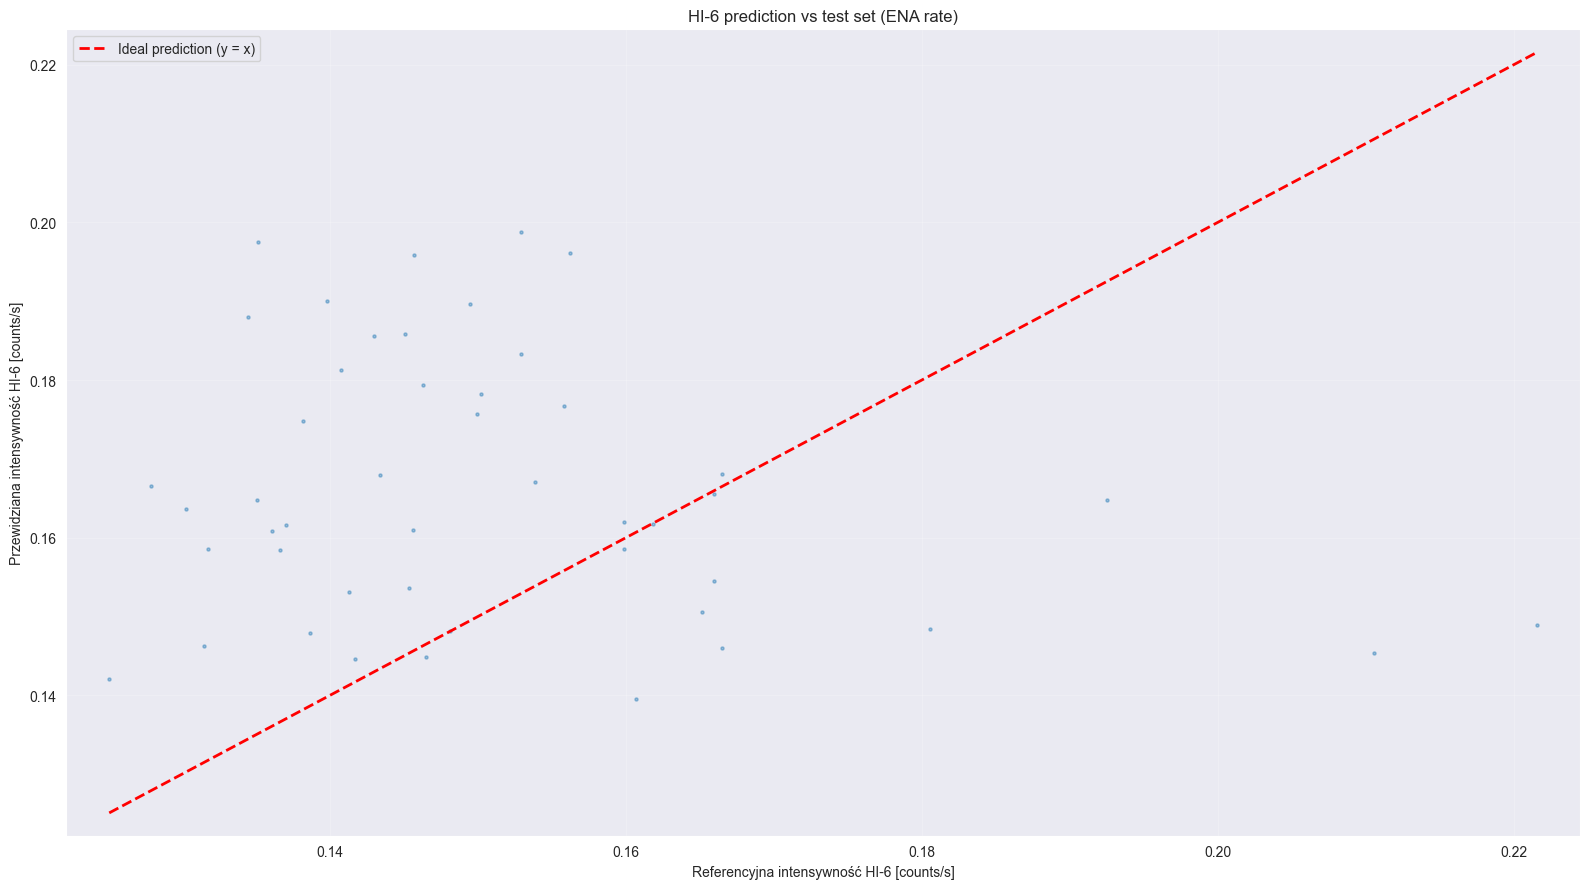

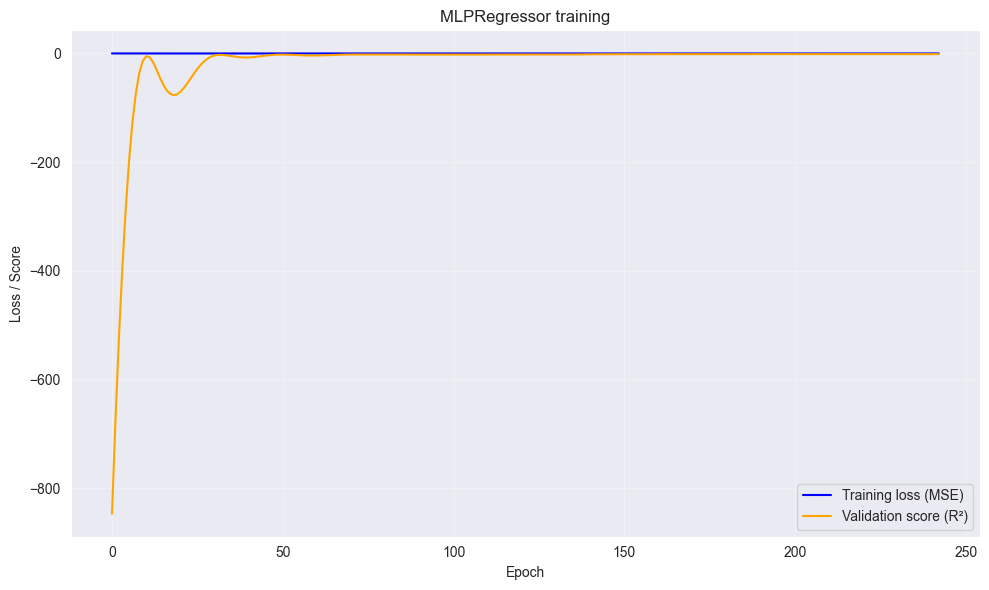

In [74]:
DATA_DIR = "channel_analyzer_out_old/AfterPerigeeChange"
OUT_DIR = "rzeczy do inż/MLPRegressor/BeforePerigeeChange/filtered"
TARGET_CHANNEL = "HI-6"

def load_channel_rate(path):
    data = np.loadtxt(path, skiprows=1)
    counts = data[:, 0]
    dt = data[:, 1]
    rate = counts / dt
    return rate

channel_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

series = []
labels = []

for ch in channel_ids:
    path = os.path.join(DATA_DIR, f"channel_{ch}_good_data.txt")
    rate = load_channel_rate(path)
    series.append(rate)
    if ch<=6:
        labels.append(f"HI-{ch}")
    else:
        labels.append(f"LO-{ch}")
min_len = min(len(s) for s in series)
series = [s[:min_len] for s in series]

data = np.column_stack(series)
print(f"Dane {TARGET_CHANNEL} (rate):", data.shape)
k = labels.index(TARGET_CHANNEL)

X = np.delete(data, k, axis=1)
y = data[:, k]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)
regr = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50,
    random_state=42
)

regr.fit(X_train, y_train)
y_pred_train = regr.predict(X_train)
y_pred_test  = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)
rmse_std = rmse / np.std(y_test)
print(f"wyniki dla {TARGET_CHANNEL}")
print(f"RMSE={rmse}")
print(f"MAE={mae}")
print(f"R²={r2}")
print(f"RMSE/STD={rmse_std}")

plot_pred_vs_true(
    y_train,
    y_pred_train,
    title=f"{TARGET_CHANNEL} prediction vs training set (ENA rate)",
    filename=f"{TARGET_CHANNEL}_train_pred_vs_true.png",
    label_x=f"Referencyjna intensywność {TARGET_CHANNEL} [counts/s]",
    label_y=f"Przewidziana intensywność {TARGET_CHANNEL} [counts/s]"
)
plot_pred_vs_true(
    y_test,
    y_pred_test,
    title=f"{TARGET_CHANNEL} prediction vs test set (ENA rate)",
    filename=f"{TARGET_CHANNEL}_test_pred_vs_true.png",
    label_x=f"Referencyjna intensywność {TARGET_CHANNEL} [counts/s]",
    label_y=f"Przewidziana intensywność {TARGET_CHANNEL} [counts/s]"
)
plot_loss_curves(
    regr,
    out_path=os.path.join(
        OUT_DIR,
        f"{TARGET_CHANNEL}_training_loss_curve.png"
    )
)


In [ ]:
REAL_DIR = "output/AfterPerigeeChange"
def load_channel_scalar(path):
    return torch.load(path)[:, 1].numpy()

channels = ([("hi", i) for i in range(1, 7)] + [("lo", i) for i in range(1, 9)])
series = []
labels = []
for ch_type, ch_num in channels:
    subdir = "Hi_data" if ch_type == "hi" else "Lo_data"
    path = os.path.join(
        REAL_DIR,
        subdir,
        f"{ch_type}_hex_channel_{ch_num}.pt"
    )
    series.append(load_channel_scalar(path))
    labels.append(f"{ch_type.upper()}-{ch_num}")

TARGET_CHANNEL = "LO-8"
min_len = min(len(s) for s in series)
series = [s[:min_len] for s in series]
data = np.column_stack(series)
print("Dane wczytane:", data.shape)
k = labels.index(TARGET_CHANNEL)
X = np.delete(data, k, axis=1)
y = data[:, k]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
regr = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
rmse_std = rmse / np.std(y_test)
print(f"Channel: {TARGET_CHANNEL} -  RMSE ={rmse:.3f}, MAE={mae:.3f}, R²= {r2:.4f}, RMSE/STD={rmse_std:.3f}\n")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.figure(figsize=(16, 9))
plt.scatter(y_test, y_pred, s=5, alpha=0.4)
min_val = y_test.min()
max_val = y_test.max()
plt.plot([min_val, max_val],[min_val, max_val],linestyle="--",color="red",linewidth=2,label="Idealna predykcja (y = x)")
pad = 0.01
dx = max_val - min_val
plt.xlim(min_val - pad*dx, max_val + pad*dx)
plt.ylim(min_val - pad*dx, max_val + pad*dx)
plt.xlabel(f"Wartości referencyjne kanału {TARGET_CHANNEL}")
plt.ylabel(f"Wartości przewidziane kanału {TARGET_CHANNEL}")
plt.title(f"Porównanie danych referencyjnych i przewidzianych dla kanału {TARGET_CHANNEL} (MLPRegressor)")
plt.legend(loc="upper left")
plt.grid(alpha=0.1)
plt.tight_layout()
plt.show()

In [3]:
from sklearn.feature_selection import mutual_info_regression

REAL_DIR = "output/BeforePerigeeChange"
channels = ([("hi", i) for i in range(1, 7)] + [("lo", i) for i in range(1, 9)])
def load_channel_scalar(path):
    return torch.load(path)[:, 1].numpy()

series = []
labels = []

for ch_type, ch_num in channels:
    subdir = "Hi_data" if ch_type == "hi" else "Lo_data"
    path = os.path.join(REAL_DIR,subdir,f"{ch_type}_hex_channel_{ch_num}.pt")
    series.append(load_channel_scalar(path))
    labels.append(f"{ch_type.upper()}-{ch_num}")
min_len = min(len(s) for s in series)
series = [s[:min_len] for s in series]
print("Loading tensors done")
data = np.column_stack(series)
results = {}

for k, label in enumerate(labels):
    X = np.delete(data, k, axis=1)
    y = data[:, k]
    mi = mutual_info_regression(X, y,random_state=42,n_neighbors=5)
    total_mi = mi.sum()
    results[label] = {"total_mi": total_mi,"mean_mi": mi.mean(),"max_mi": mi.max()}
    print(f"\n=== {label} ===")
    print(f"Total MI : {total_mi:.6f}")
    print(f"Mean  MI : {mi.mean():.6f}")
    print(f"Max   MI : {mi.max():.6f}")

print("\n=== SUMMARY (Mutual Information) ===")
for ch, vals in results.items():
    print(
        f"{ch:6s} | "
        f"Total MI = {vals['total_mi']:.6f} | "
        f"Mean MI = {vals['mean_mi']:.6f} | "
        f"Max MI = {vals['max_mi']:.6f}"
    )

Loading tensors done

=== HI-1 ===
Total MI : 0.519991
Mean  MI : 0.039999
Max   MI : 0.086491

=== HI-2 ===
Total MI : 0.640860
Mean  MI : 0.049297
Max   MI : 0.111885

=== HI-3 ===
Total MI : 0.612360
Mean  MI : 0.047105
Max   MI : 0.103927

=== HI-4 ===
Total MI : 0.558715
Mean  MI : 0.042978
Max   MI : 0.095202

=== HI-5 ===
Total MI : 0.492809
Mean  MI : 0.037908
Max   MI : 0.082639

=== HI-6 ===
Total MI : 0.416666
Mean  MI : 0.032051
Max   MI : 0.067315

=== LO-1 ===
Total MI : 3.274541
Mean  MI : 0.251888
Max   MI : 0.791372

=== LO-2 ===
Total MI : 3.492676
Mean  MI : 0.268667
Max   MI : 0.902675

=== LO-3 ===
Total MI : 3.377512
Mean  MI : 0.259809
Max   MI : 0.875405

=== LO-4 ===
Total MI : 1.308556
Mean  MI : 0.100658
Max   MI : 0.256204

=== LO-5 ===
Total MI : 0.819207
Mean  MI : 0.063016
Max   MI : 0.166160

=== LO-6 ===
Total MI : 1.076989
Mean  MI : 0.082845
Max   MI : 0.210116

=== LO-7 ===
Total MI : 1.260151
Mean  MI : 0.096935
Max   MI : 0.258850

=== LO-8 ===
Tot

Channel lengths: [1526, 2837, 3492, 4424, 4766, 4291, 267, 186, 186, 186, 186, 200, 267, 267]
Using min length: 186
Input channels: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
X shape: (186, 13)
y shape: (186,)
TRAIN:
RMSE = 41.06659225981787
R²   = 0.9994149775246259
RMSE/STD =  0.024187237861608687

TEST:
RMSE = 2033.374456168458
R²   = -1.1273885813048414
RMSE/STD =  1.4585570202446119

=== FIRST 20 TRAIN SAMPLES FED INTO MLP (AFTER SCALING) ===
Sample 00 | X = [ 0.452 -0.373 -0.577  0.63  -0.326 -0.903 -0.846 -0.587 -0.283 -0.14
 -0.22  -0.921 -0.984] | y = 1977.000
Sample 01 | X = [-0.462  0.487 -0.311 -0.595 -0.66  -0.187  0.057 -0.107 -0.189 -0.254
 -0.023  0.353  0.421] | y = 629.000
Sample 02 | X = [-0.737  3.986  2.028  0.907 -0.312 -0.166  1.858  2.01   2.193  2.131
 -0.881 -0.902 -0.969] | y = 8690.000
Sample 03 | X = [-0.697 -0.594 -0.506 -0.486 -0.344  0.433  0.965  1.1    1.23   1.1
  0.515  0.374  0.413] | y = 384.000
Sample 04 | X = [-0.814 -0.683 -0.386 -0.337 -0.375

D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


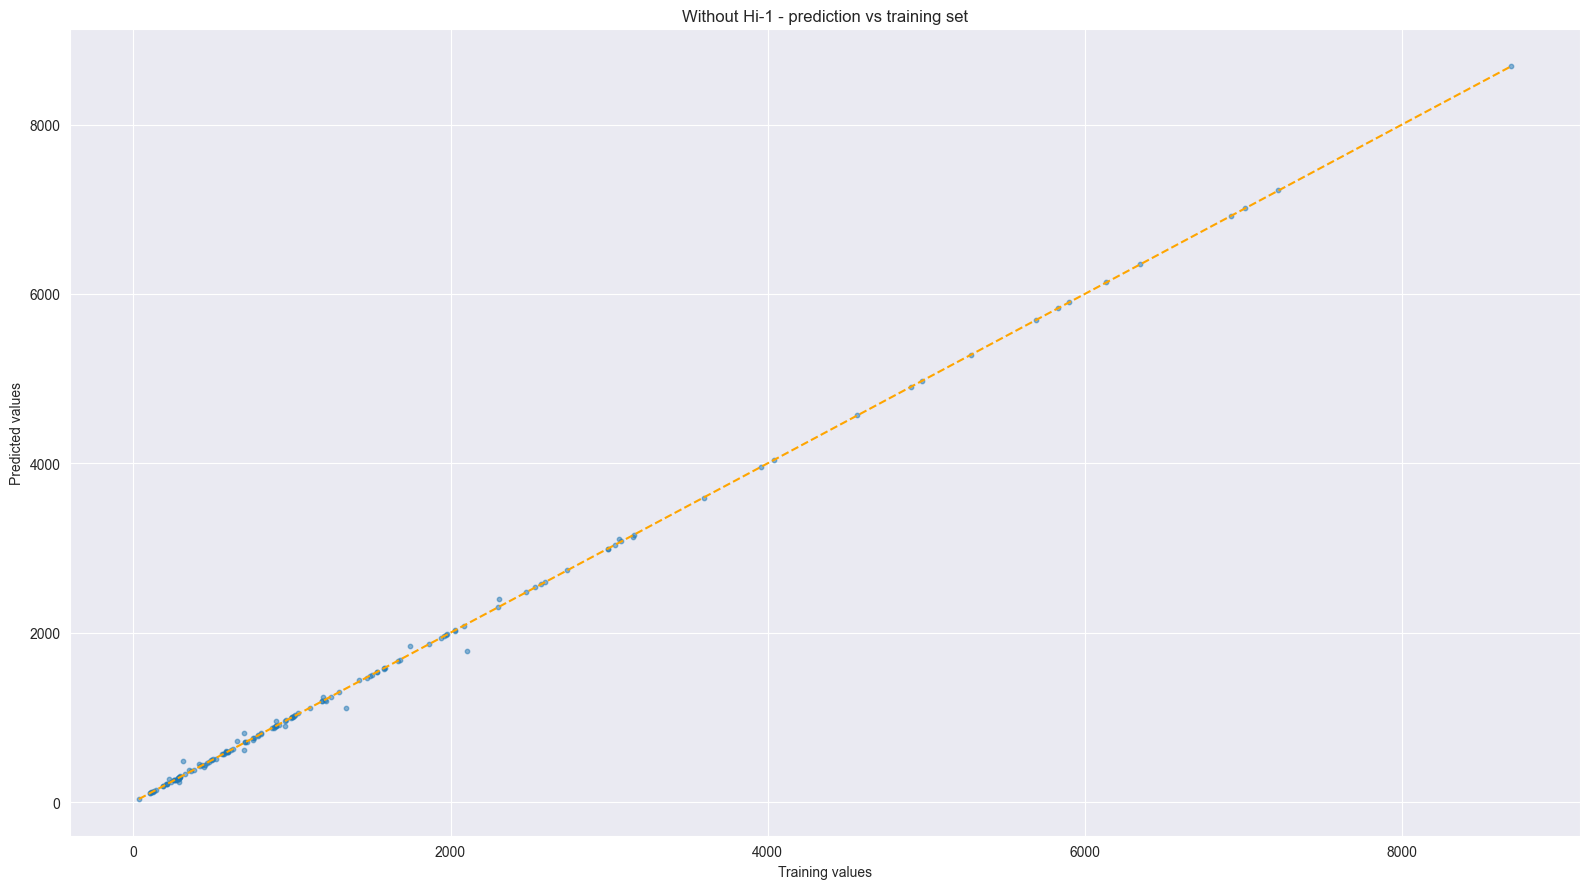

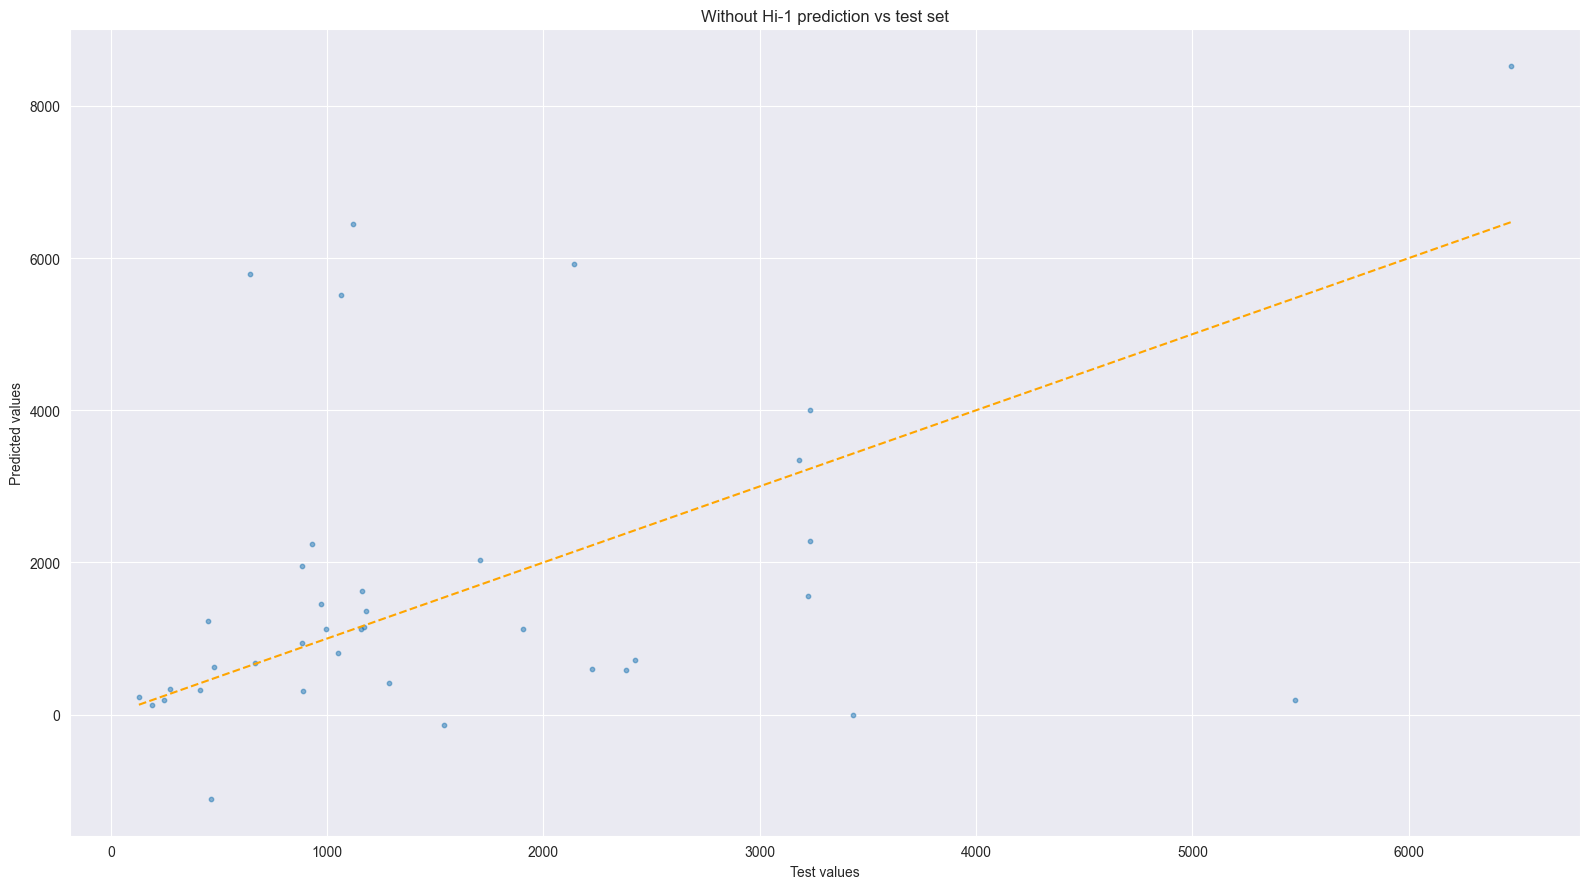

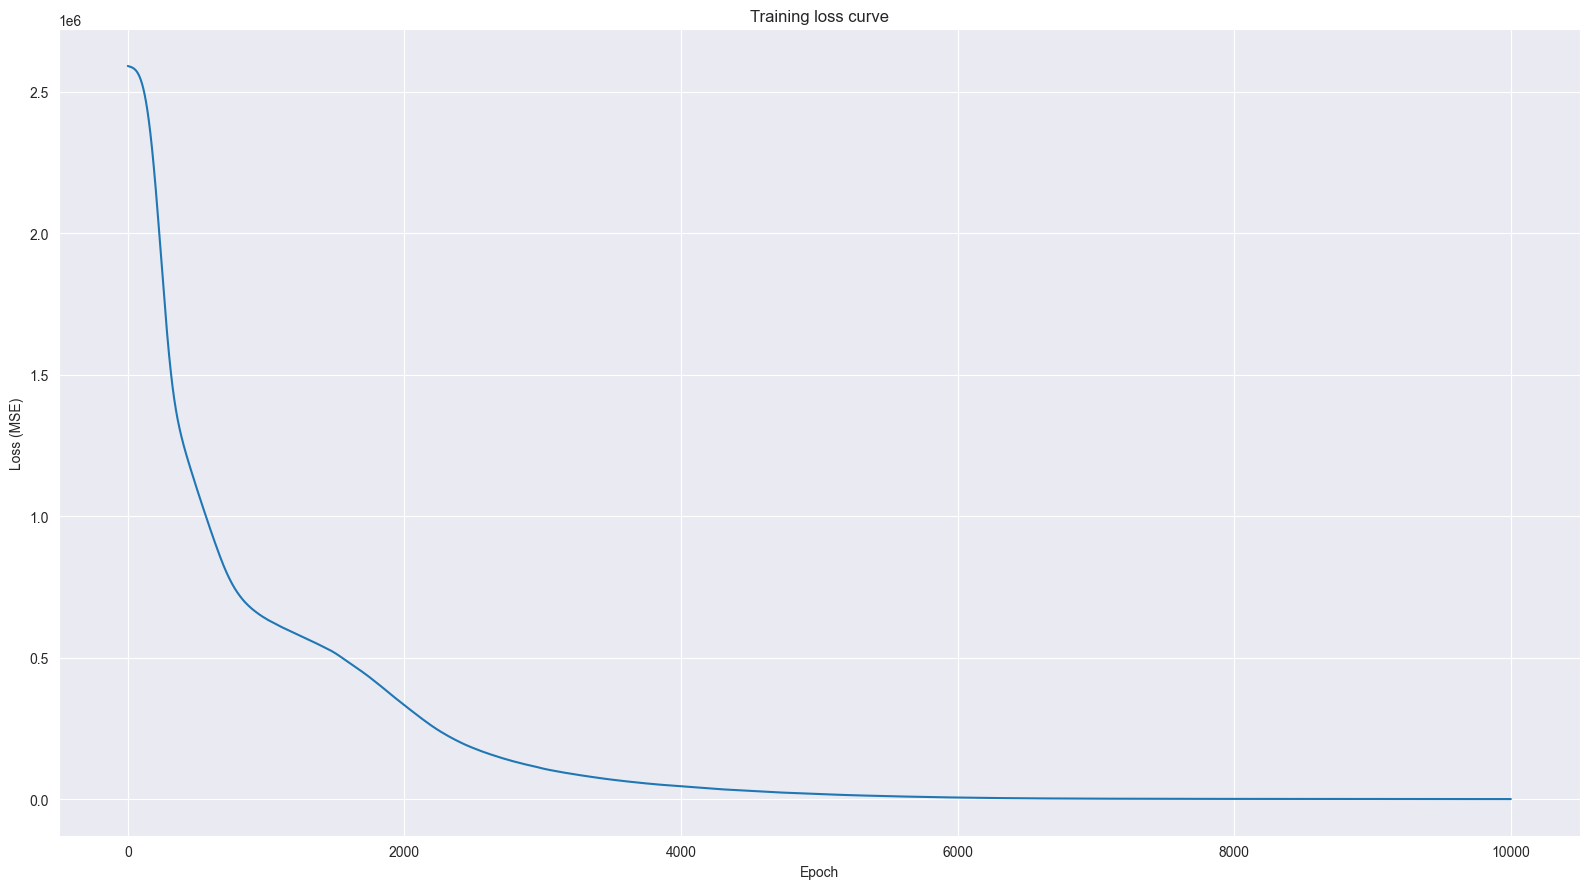

In [6]:
DATA_DIR = "channel_analyzer_out_old/AfterPerigeeChange"
TARGET_CHANNEL = 1   # channel_3_good_data.txt

channel_sums = []
channel_ids = []
lengths = []

for ch in range(1, 15):
    file_path = os.path.join(
        DATA_DIR, f"channel_{ch}_good_data.txt"
    )

    data = np.loadtxt(file_path, skiprows=1)
    sum_col = data[:, 0]
    lengths.append(len(sum_col))

    if ch == TARGET_CHANNEL:
        y = sum_col
    else:
        channel_sums.append(sum_col)
        channel_ids.append(ch)

min_len = min(lengths)
print("Channel lengths:", lengths)
print("Using min length:", min_len)
channel_sums_trimmed = [c[:min_len] for c in channel_sums]
y = y[:min_len]

X = np.column_stack(channel_sums_trimmed)

print("Input channels:", channel_ids)
print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train_raw = X_train.copy()
X_test_raw  = X_test.copy()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    max_iter=10000,
    random_state=42
)

mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred  = mlp.predict(X_test)
print("TRAIN:")
print("RMSE =", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²   =", r2_score(y_train, y_train_pred))
print("RMSE/STD = ", np.sqrt(mean_squared_error(y_train, y_train_pred))/np.std(y_train))

print("\nTEST:")
print("RMSE =", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²   =", r2_score(y_test, y_test_pred))
print("RMSE/STD = ", np.sqrt(mean_squared_error(y_test, y_test_pred))/np.std(y_test))
plt.figure(figsize=(16, 9))
plt.scatter(y_train, y_train_pred, s=10, alpha=0.5)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    linestyle="--",
    color="orange"
)
np.set_printoptions(precision=3, suppress=True)

print("\n=== FIRST 20 TRAIN SAMPLES FED INTO MLP (AFTER SCALING) ===")
for i in range(20):
    print(f"Sample {i:02d} | X = {X_train[i]} | y = {y_train[i]:.3f}")

print("\n=== FIRST 5 TRAIN SAMPLES: RAW vs SCALED ===")
for i in range(10):
    print(f"\nSample {i:02d}")
    print("RAW   X =", X_train_raw[i])
    print("SCALED X =", X_train[i])
    print("y =", y_train[i])

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)
rmse_std = rmse / np.std(y_test)
print(f"wyniki dla {TARGET_CHANNEL}")
print(f"RMSE={rmse}")
print(f"MAE={mae}")
print(f"R²={r2}")
print(f"RMSE/STD={rmse_std}")

plt.xlabel("Training values")
plt.ylabel("Predicted values")
plt.title("Without Hi-1 - prediction vs training set")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(y_test, y_test_pred, s=10, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="orange"
)
plt.xlabel("Test values")
plt.ylabel("Predicted values")
plt.title("Without Hi-1 prediction vs test set")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training loss curve")
plt.grid(True)
plt.tight_layout()
plt.show()

Using common length: 186
X shape: (186, 208)
y shape: (186, 16)
Best alpha selected by CV: 221.22162910704503
==== TRAINING ====
RMSE (global): 0.6427
MAE  (global): 0.4538
RMSE (physical units): 245.2786
MAE  (physical units): 42.9772
==== TEST ====

TARGET CHANNEL = 1
RMSE (global): 0.8704
MAE  (global): 0.6297
RMSE (physical units): 312.2831
MAE  (physical units): 57.2354


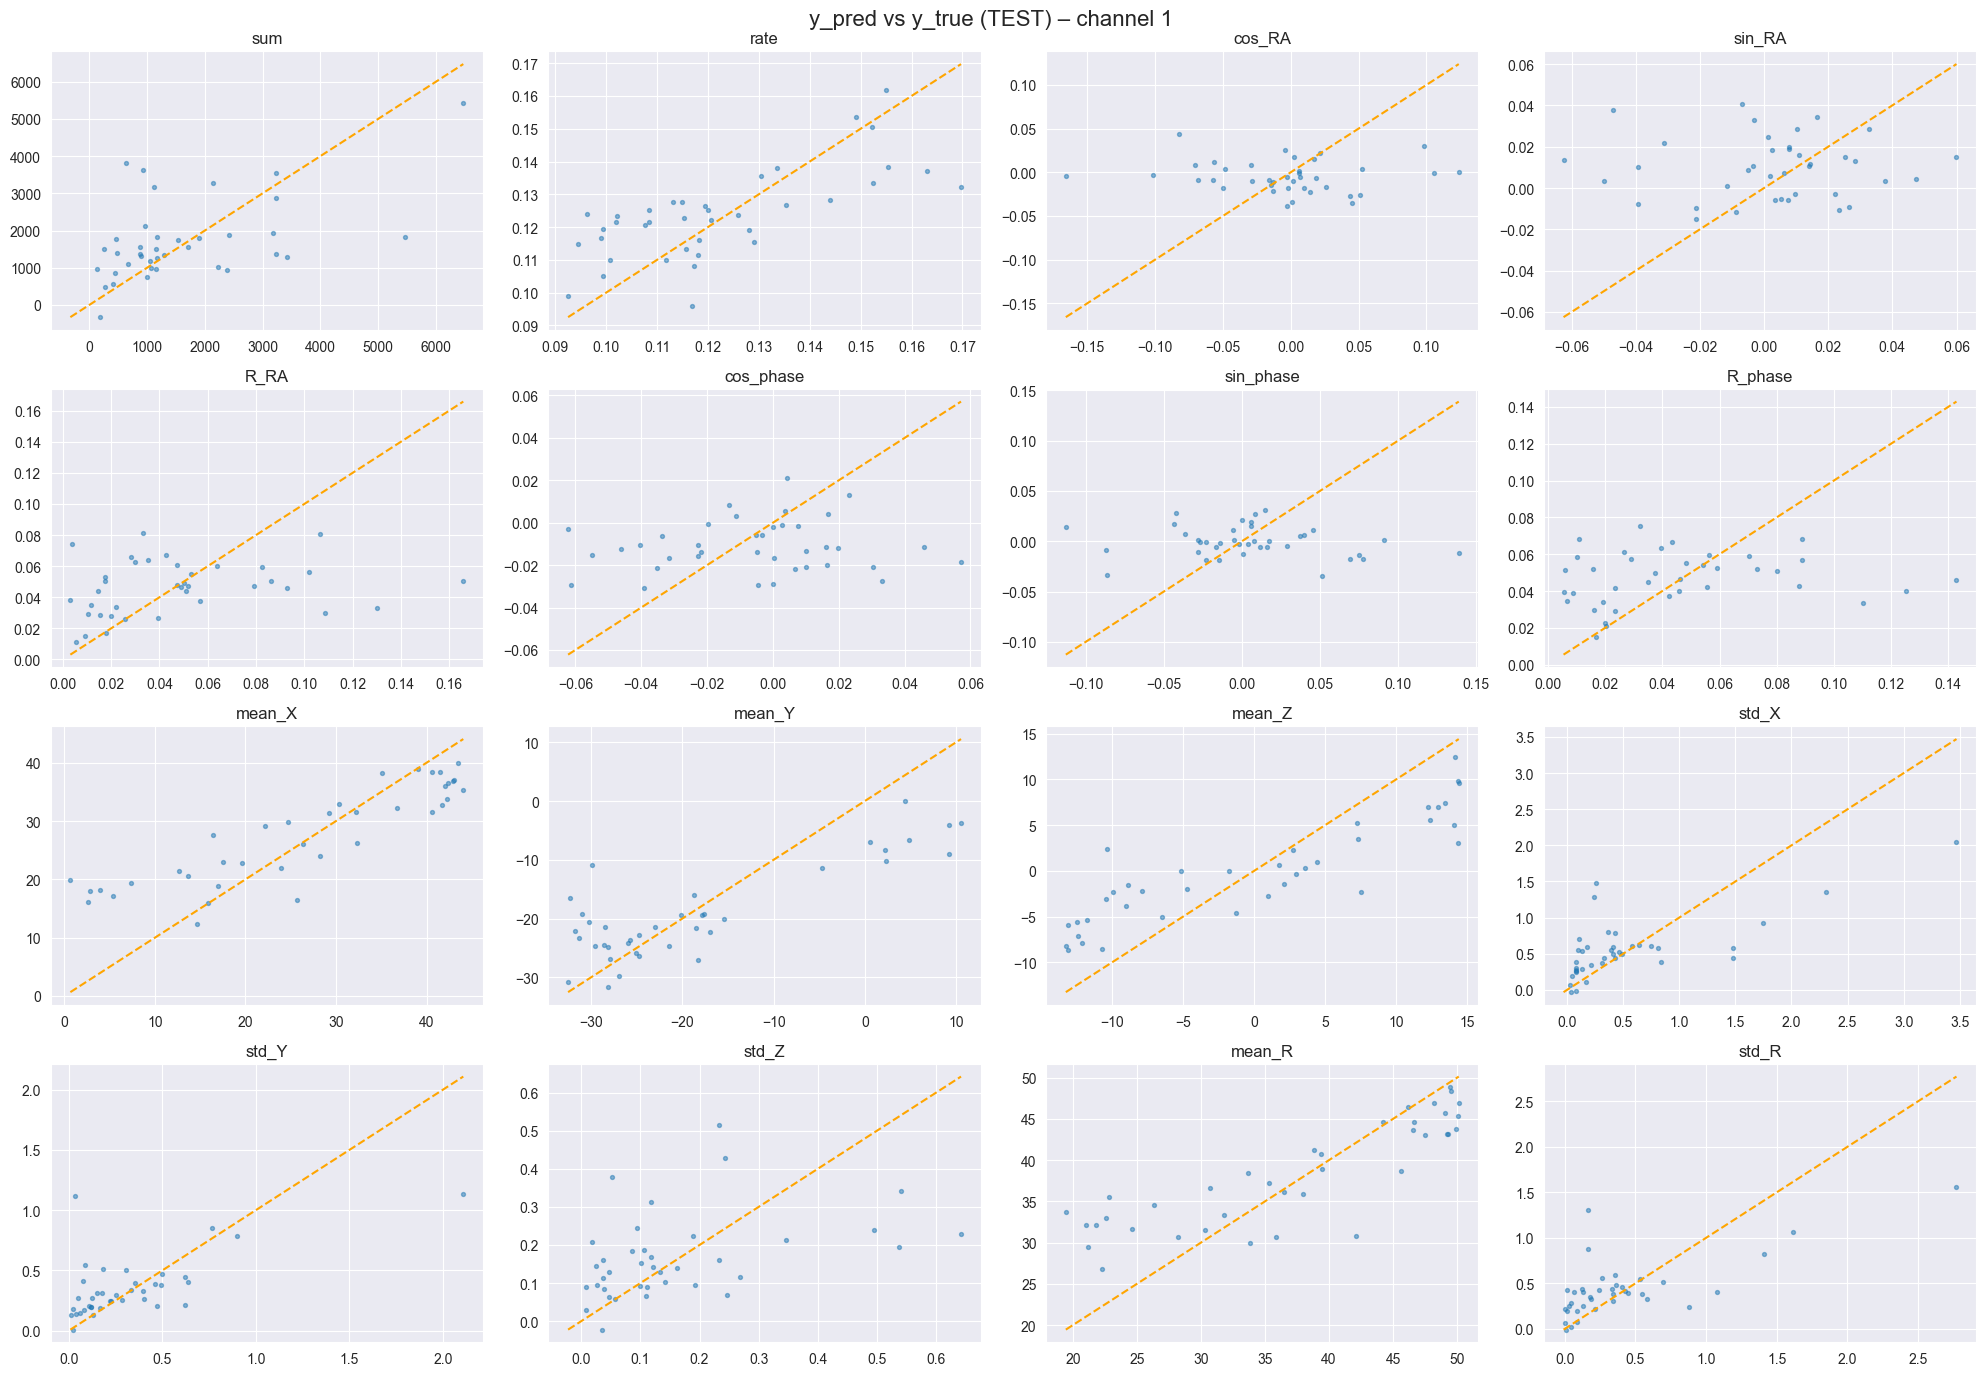

Ridge coefficients shape: (16, 208)


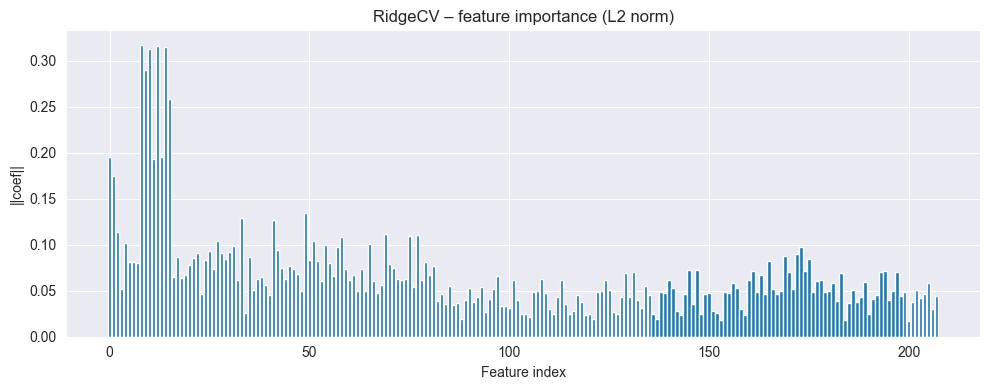

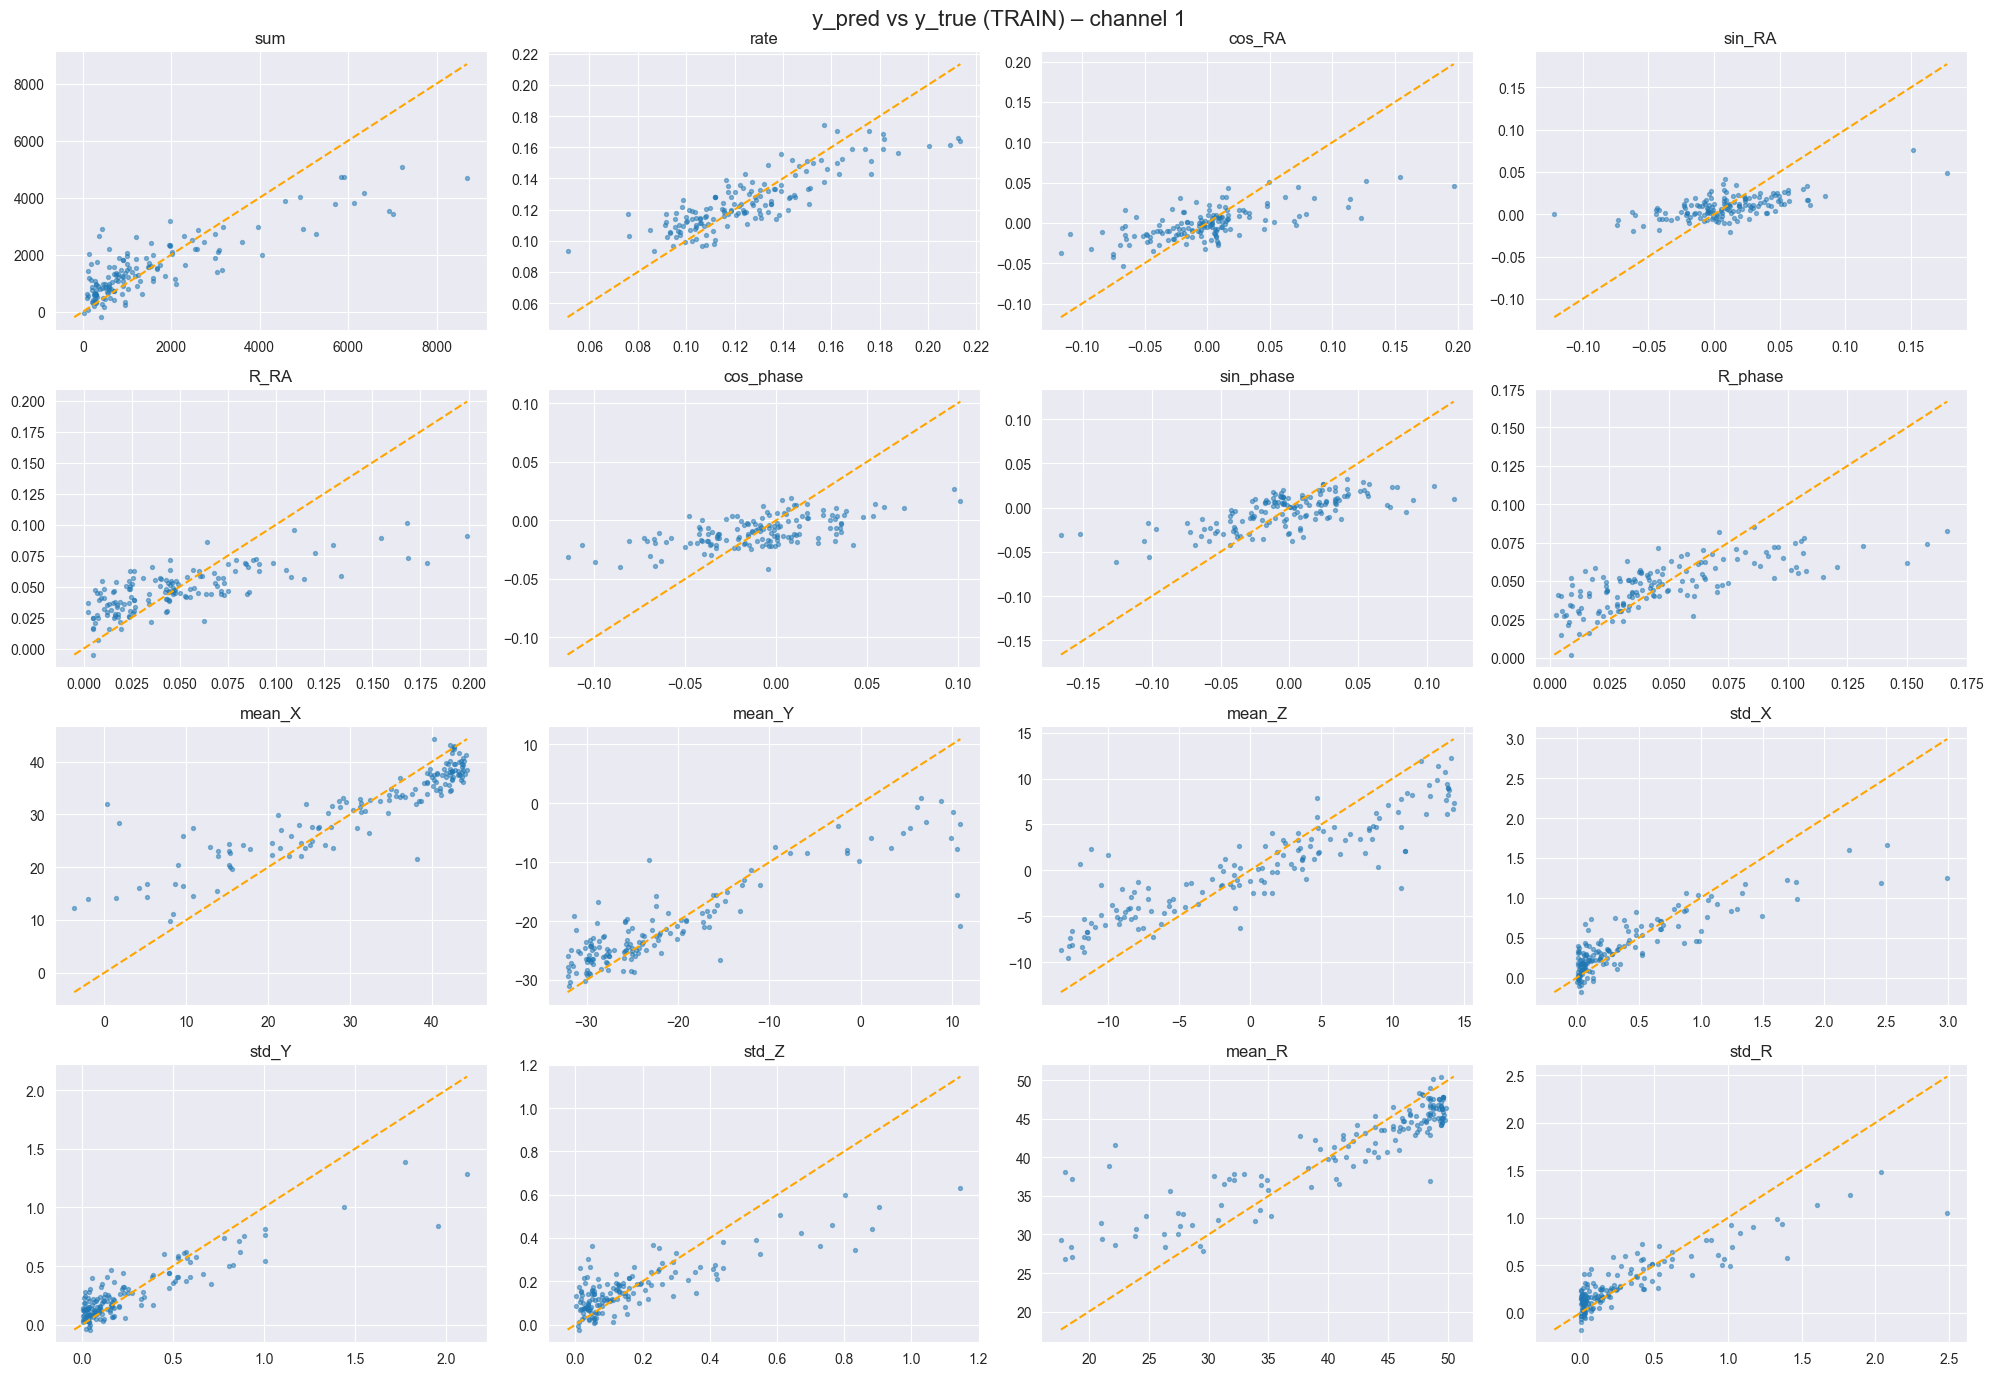

In [25]:
# CONF
from sklearn.linear_model import RidgeCV
DATA_DIR = "channel_analyzer_out_aggregated/AfterPerigeeChange"
TARGET_CHANNEL = 1

FEATURE_IDXS = [
    0,      # sum
    4,      # rate
    5, 6, 7,
    8, 9, 10
    ,11, 12, 13,
    14, 15, 16,
    17, 18
]
# LOAD DATA
channel_data = {}
lengths = []

for ch in range(1, 15):
    path = os.path.join(DATA_DIR, f"channel_{ch}_good_data_aggregated.txt")
    data = np.loadtxt(path, skiprows=1)
    channel_data[ch] = data
    lengths.append(len(data))

min_len = min(lengths)
print("Using common length:", min_len)
# BUILD X, y
X_list = []
y_list = []

for i in range(min_len):
    x_row = []

    for ch in range(1, 15):
        features = channel_data[ch][i, FEATURE_IDXS]

        if ch == TARGET_CHANNEL:
            y_row = features
        else:
            x_row.extend(features)

    X_list.append(x_row)
    y_list.append(y_row)

X = np.array(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y shape:", y.shape)
#SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# SCALE
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test  = scaler_y.transform(y_test)
alphas = np.logspace(-4, 4, 30)
# MODEL
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-4,
    max_iter=10000,
    tol=1e-7
)
# model = Ridge(
#     alpha=0.1,
#     fit_intercept=True
# )
# model = RidgeCV(
#     alphas=alphas,
#     cv=5,                 # 5-fold CV
#     fit_intercept=True,
#     scoring="neg_mean_squared_error"
# )
mlp.fit(X_train, y_train)
# model.fit(X_train, y_train)
# print("Best alpha selected by CV:", model.alpha_)
# PREDICT
y_train_pred = mlp.predict(X_train)
y_test_pred  = mlp.predict(X_test)
# y_train_pred = model.predict(X_train)
# y_test_pred  = model.predict(X_test)
# METRICS (global)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
# INVERSE SCALE (y)
y_train_true_phys = scaler_y.inverse_transform(y_train)
y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
y_test_true_phys  = scaler_y.inverse_transform(y_test)
y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)
rmse_phys = np.sqrt(mean_squared_error(y_test_true_phys, y_test_pred_phys))
mae_phys  = mean_absolute_error(y_test_true_phys, y_test_pred_phys)
rmse_phys_train = np.sqrt(mean_squared_error(y_train_true_phys, y_train_pred_phys))
mae_phys_train  = mean_absolute_error(y_train_true_phys, y_train_pred_phys)
print("==== TRAINING ====")
print(f"RMSE (global): {rmse_train:.4f}")
print(f"MAE  (global): {mae_train:.4f}")
print(f"RMSE (physical units): {rmse_phys_train:.4f}")
print(f"MAE  (physical units): {mae_phys_train:.4f}")

print("==== TEST ====")
print(f"\nTARGET CHANNEL = {TARGET_CHANNEL}")
print(f"RMSE (global): {rmse:.4f}")
print(f"MAE  (global): {mae:.4f}")
print(f"RMSE (physical units): {rmse_phys:.4f}")
print(f"MAE  (physical units): {mae_phys:.4f}")

# PLOTS
FEATURE_NAMES = [
    "sum", "rate",
    "cos_RA", "sin_RA", "R_RA",
    "cos_phase", "sin_phase", "R_phase"
    ,"mean_X", "mean_Y", "mean_Z",
    "std_X", "std_Y", "std_Z",
    "mean_R", "std_R"
]

#y_pred vs y_true (TEST)
fig, axes = plt.subplots(4, 4, figsize=(20, 14))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
    ax.scatter(
        y_test_true_phys[:, i],
        y_test_pred_phys[:, i],
        s=8,
        alpha=0.5
    )
    lims = [
        min(y_test_true_phys[:, i].min(), y_test_pred_phys[:, i].min()),
        max(y_test_true_phys[:, i].max(), y_test_pred_phys[:, i].max())
    ]
    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(FEATURE_NAMES[i])
    ax.grid(True)

plt.suptitle(f"y_pred vs y_true (TEST) – channel {TARGET_CHANNEL}", fontsize=16)
plt.tight_layout()
plt.show()

#Training loss plot
plt.figure(figsize=(10, 5))
plt.plot(mlp.loss_curve_, label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MLP training loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# coef = model.coef_          # shape: (n_targets, n_features)
# print("Ridge coefficients shape:", coef.shape)
# coef_norm = np.linalg.norm(coef, axis=0)

# plt.figure(figsize=(10, 4))
# plt.bar(range(len(coef_norm)), coef_norm)
# plt.xlabel("Feature index")
# plt.ylabel("||coef||")
# plt.title("RidgeCV – feature importance (L2 norm)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# fig, axes = plt.subplots(4, 4, figsize=(20, 14))
# axes = axes.flatten()

for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
    ax.scatter(
        y_train_true_phys[:, i],
        y_train_pred_phys[:, i],
        s=8,
        alpha=0.5
    )

    lims = [
        min(y_train_true_phys[:, i].min(), y_train_pred_phys[:, i].min()),
        max(y_train_true_phys[:, i].max(), y_train_pred_phys[:, i].max())
    ]

    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(FEATURE_NAMES[i])
    ax.grid(True)

plt.suptitle(
    f"y_pred vs y_true (TRAIN) – channel {TARGET_CHANNEL}",
    fontsize=16
)
plt.tight_layout()
plt.show()

Using common length: 186


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  1 | RMSE/STD (TEST) = 0.763


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  2 | RMSE/STD (TEST) = 0.785


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  3 | RMSE/STD (TEST) = 1.182


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  4 | RMSE/STD (TEST) = 1.110


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  5 | RMSE/STD (TEST) = 0.936


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  6 | RMSE/STD (TEST) = 1.147


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  7 | RMSE/STD (TEST) = 0.731


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  8 | RMSE/STD (TEST) = 0.372


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel  9 | RMSE/STD (TEST) = 0.150


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel 10 | RMSE/STD (TEST) = 0.178


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel 11 | RMSE/STD (TEST) = 0.163


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel 12 | RMSE/STD (TEST) = 0.467


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel 13 | RMSE/STD (TEST) = 0.361


D:\Moje dane\Programy Python\IBEX_Framework\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  warnings.warn(


Channel 14 | RMSE/STD (TEST) = 0.593


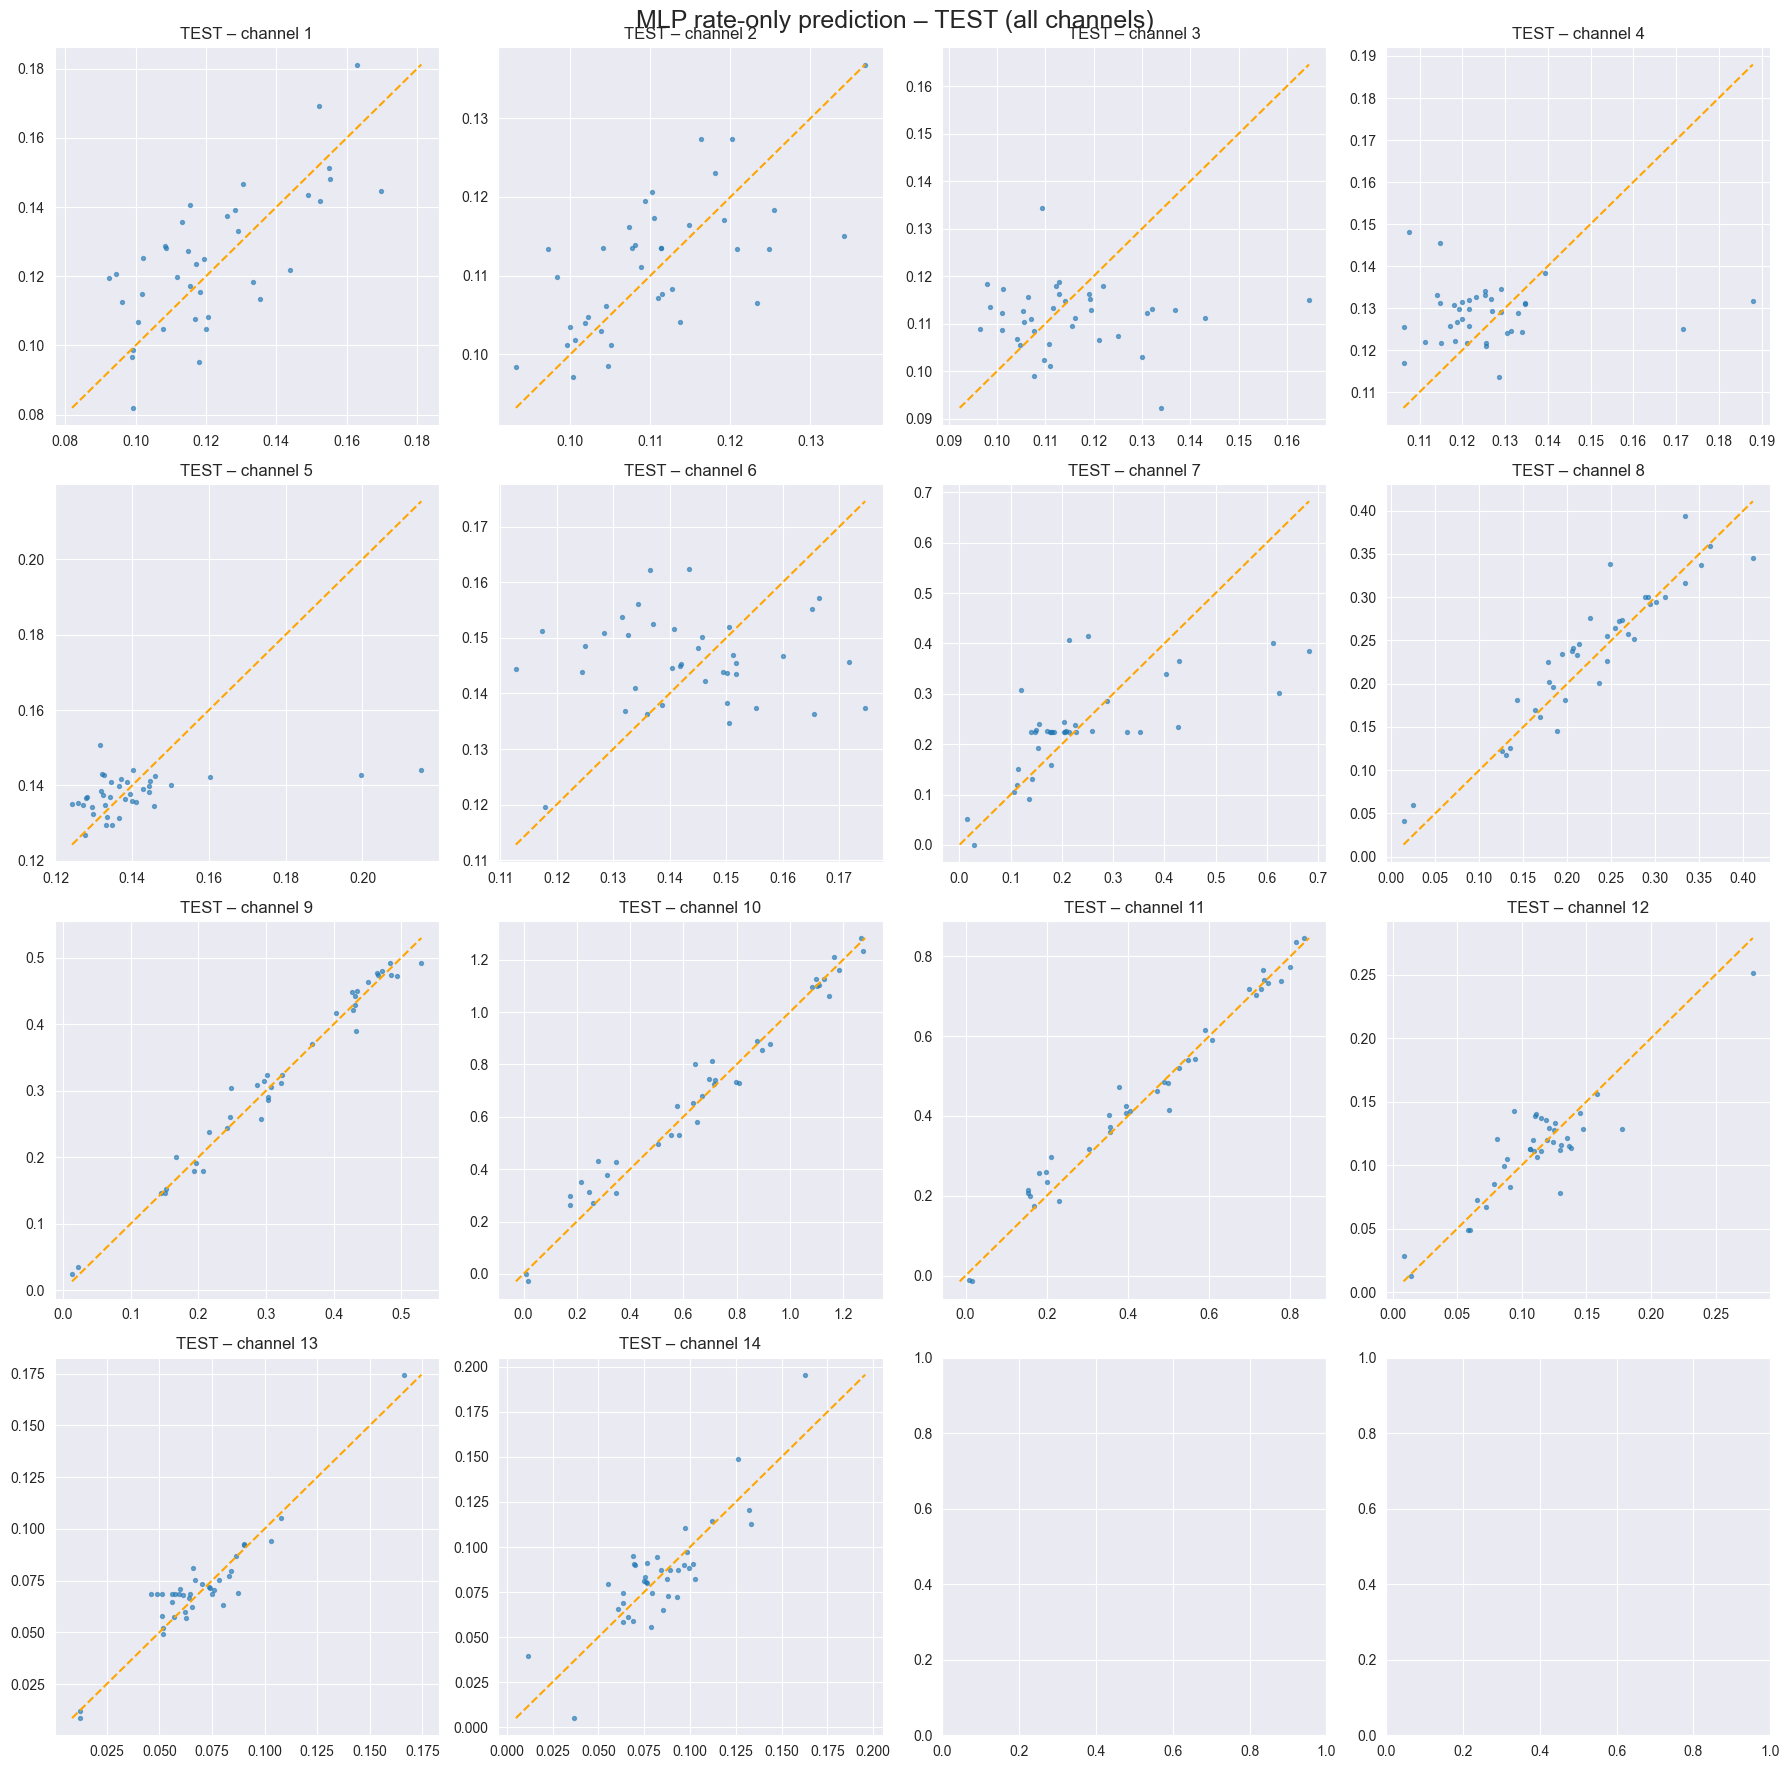

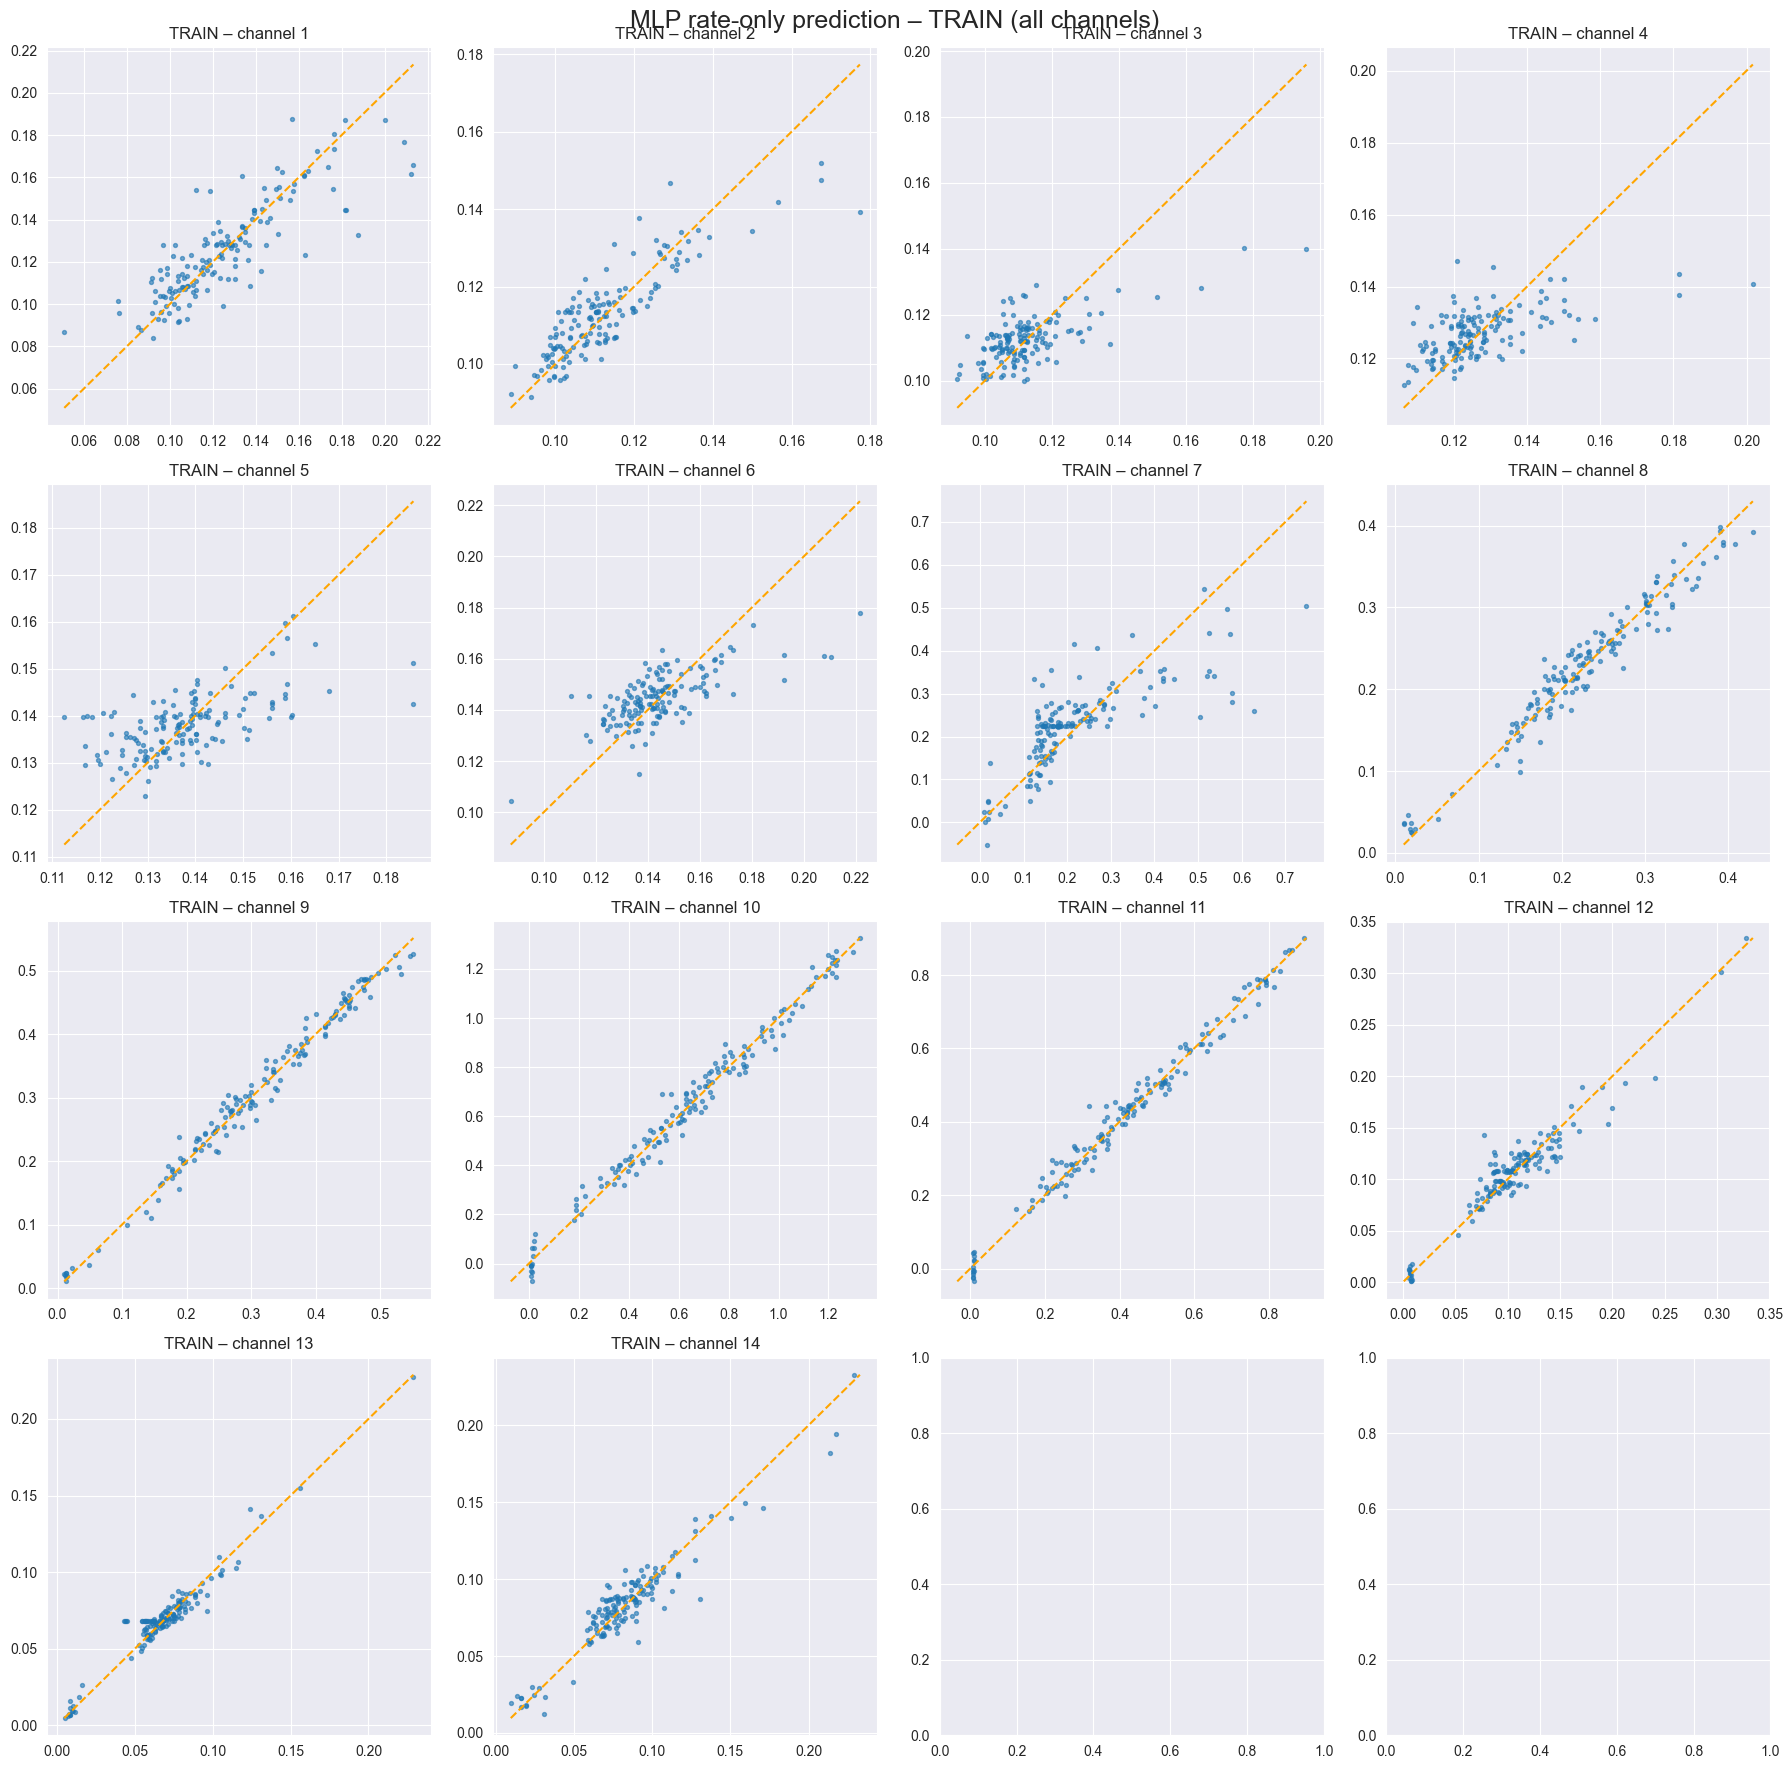

In [75]:
DATA_DIR = "channel_analyzer_out_aggregated/AfterPerigeeChange"
RATE_IDX = 4
CHANNELS = range(1, 15)
channel_data = {}
lengths = []

for ch in CHANNELS:
    path = os.path.join(DATA_DIR, f"channel_{ch}_good_data_aggregated.txt")
    data = np.loadtxt(path, skiprows=1)
    channel_data[ch] = data
    lengths.append(len(data))

min_len = min(lengths)
print("Using common length:", min_len)
results = {}
predictions = {}
for TARGET_CHANNEL in CHANNELS:
    X_list, y_list = [], []

    for i in range(min_len):
        x_row = []
        for ch in CHANNELS:
            rate = channel_data[ch][i, RATE_IDX]
            if ch == TARGET_CHANNEL:
                y_val = rate
            else:
                x_row.append(rate)
        X_list.append(x_row)
        y_list.append(y_val)

    X = np.array(X_list)
    y = np.array(y_list).reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test  = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train)
    y_test  = scaler_y.transform(y_test)

    mlp = MLPRegressor(
        hidden_layer_sizes=(8,),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-4,
        max_iter=8000,
        tol=1e-7,
        random_state=42
    )

    mlp.fit(X_train, y_train.ravel())
    y_train_pred= mlp.predict(X_train).reshape(-1, 1)
    y_test_pred  =mlp.predict(X_test).reshape(-1, 1)
    y_train_true= scaler_y.inverse_transform(y_train)
    y_train_pred = scaler_y.inverse_transform(y_train_pred)
    y_test_true= scaler_y.inverse_transform(y_test)
    y_test_pred= scaler_y.inverse_transform(y_test_pred)
    rmse_test= np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    std_test= np.std(y_test_true)
    rmse_std= rmse_test / std_test

    results[TARGET_CHANNEL] = rmse_std
    predictions[TARGET_CHANNEL] = {"train": (y_train_true, y_train_pred), "test":  (y_test_true,  y_test_pred)}
    print(f"Channel {TARGET_CHANNEL:2d} | "f"RMSE/STD (TEST) = {rmse_std:.3f}")

fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.flatten()

for i, ch in enumerate(CHANNELS):
    y_true, y_pred = predictions[ch]["test"]
    ax = axes[i]

    ax.scatter(y_true, y_pred, s=8, alpha=0.6)

    lims = [
        min(y_true.min(), y_pred.min()),
        max(y_true.max(), y_pred.max())
    ]
    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(f"TEST – channel {ch}")
    ax.grid(True)

plt.suptitle("MLP rate-only prediction – TEST (all channels)", fontsize=18)
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.flatten()

for i, ch in enumerate(CHANNELS):
    y_true, y_pred = predictions[ch]["train"]
    ax = axes[i]
    ax.scatter(y_true, y_pred, s=8, alpha=0.6)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(f"TRAIN – channel {ch}")
    ax.grid(True)

plt.suptitle("MLP rate-only prediction – TRAIN (all channels)", fontsize=18)
plt.tight_layout()
plt.show()


Using common length: 186
X shape: (186, 52)
y shape: (186, 4)
==== TRAINING ====
RMSE (global):        0.0243
MAE  (global):        0.0169
STD  (global):        1.0000
RMSE / STD (global):  0.0243
RMSE (physical):      0.0033
MAE  (physical):      0.0017
STD  (physical):      0.2380
RMSE / STD (physical):0.0138

==== TEST ====
TARGET CHANNEL = 1
RMSE (global):        1.6128
MAE  (global):        1.1529
STD  (global):        1.0309
RMSE / STD (global):  1.5644
RMSE (physical):      0.3336
MAE  (physical):      0.1470
STD  (physical):      0.3073
RMSE / STD (physical):1.0856


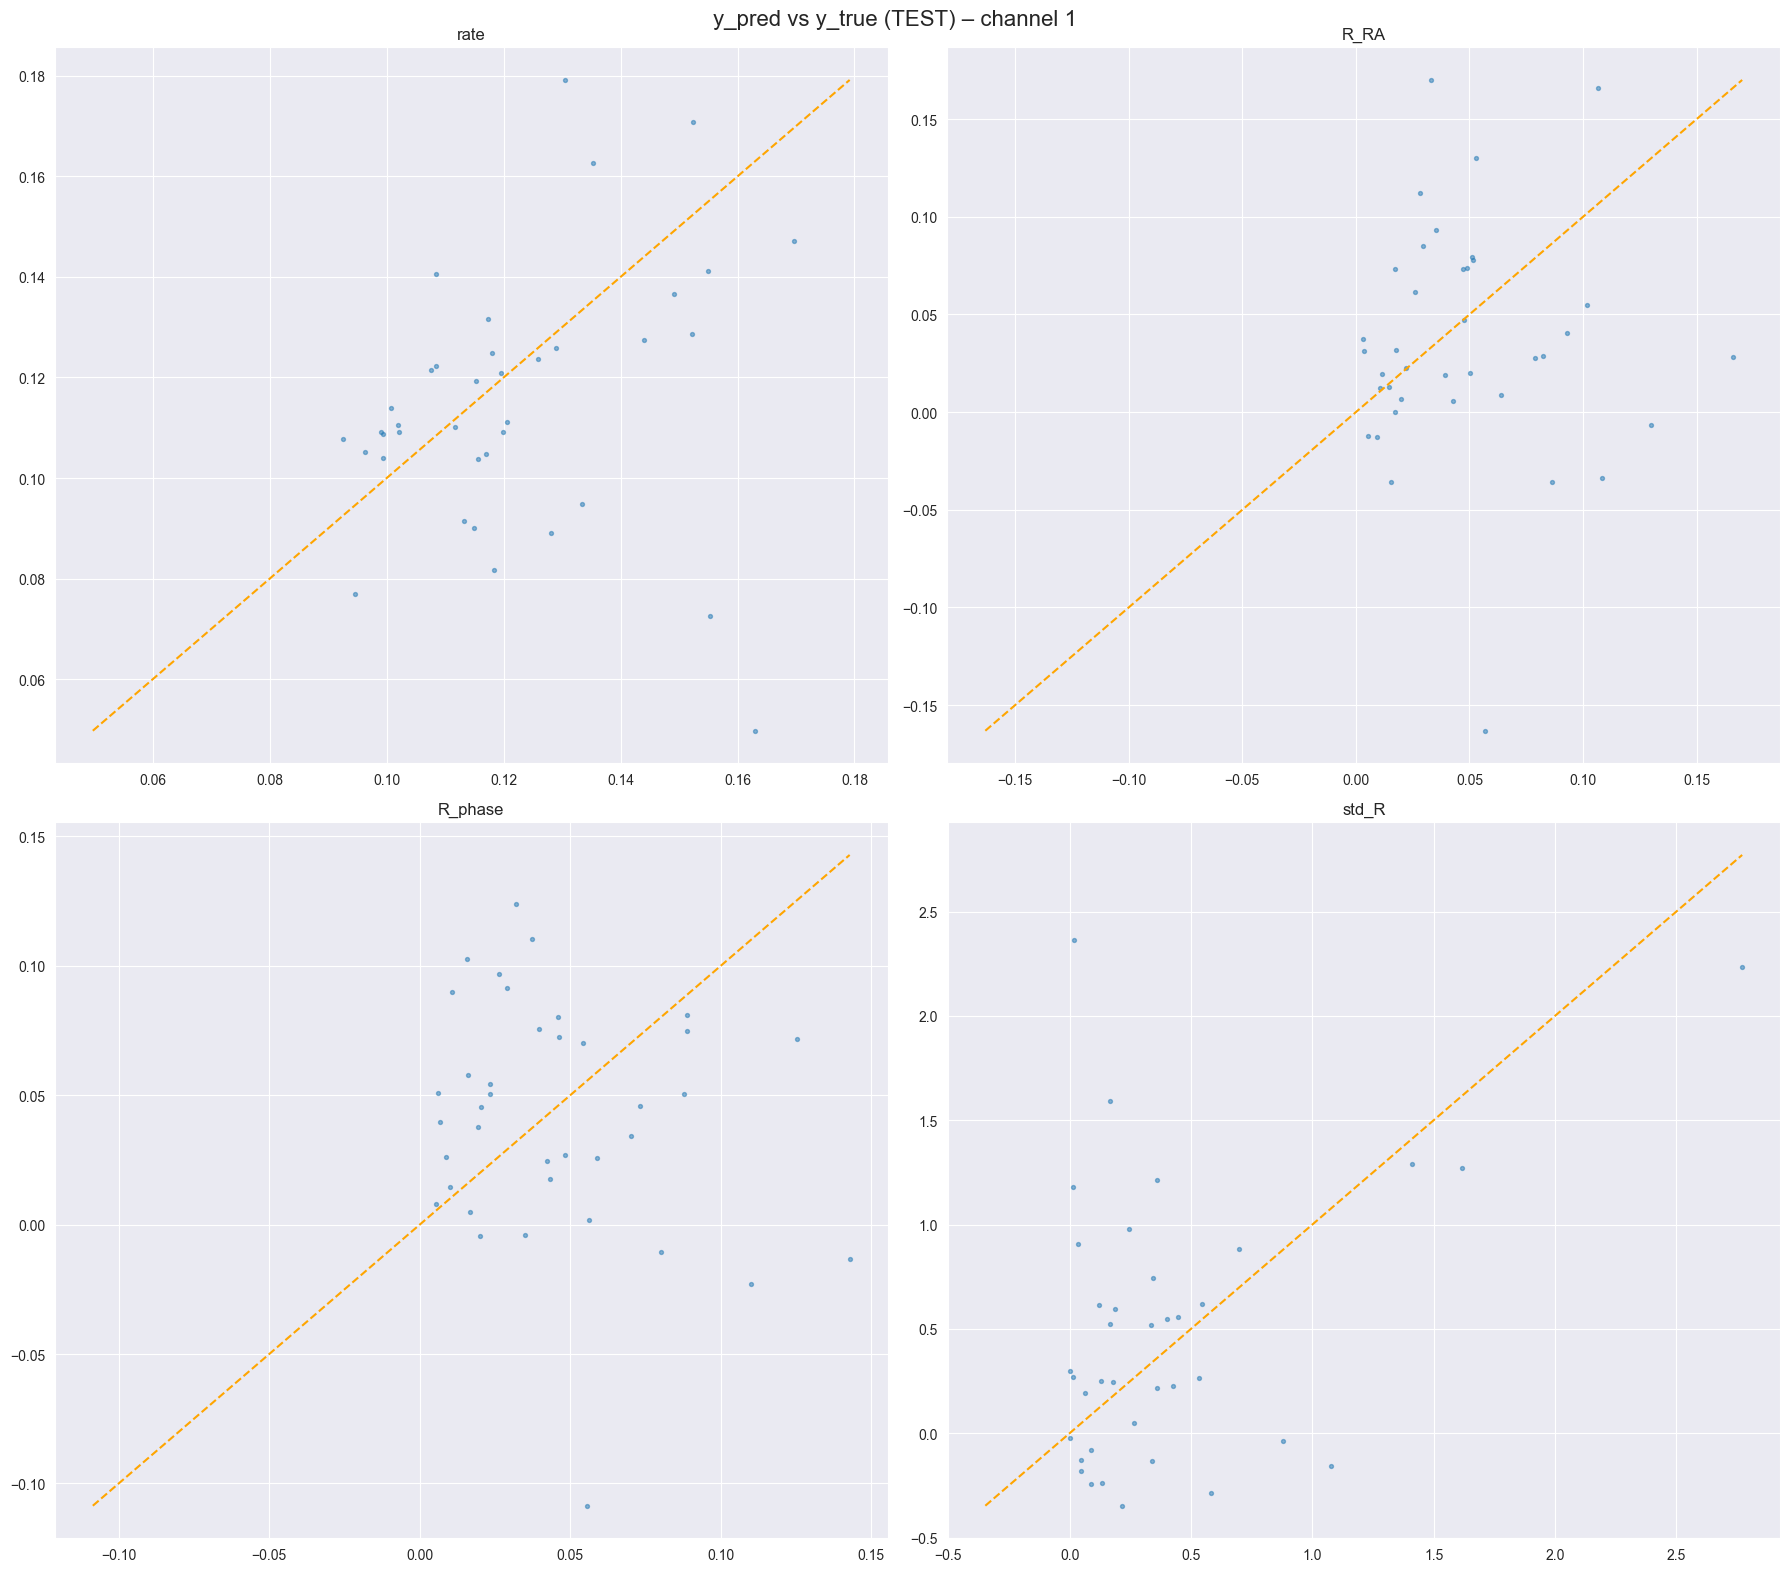

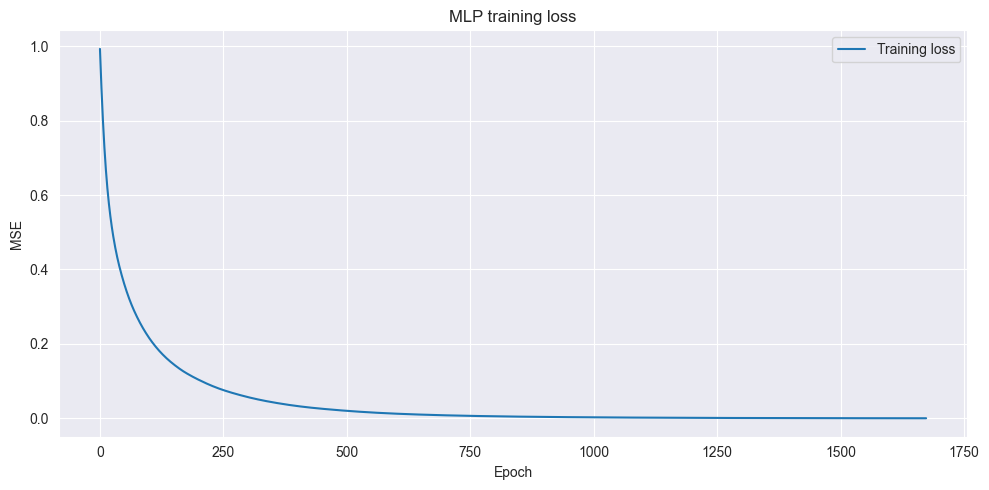

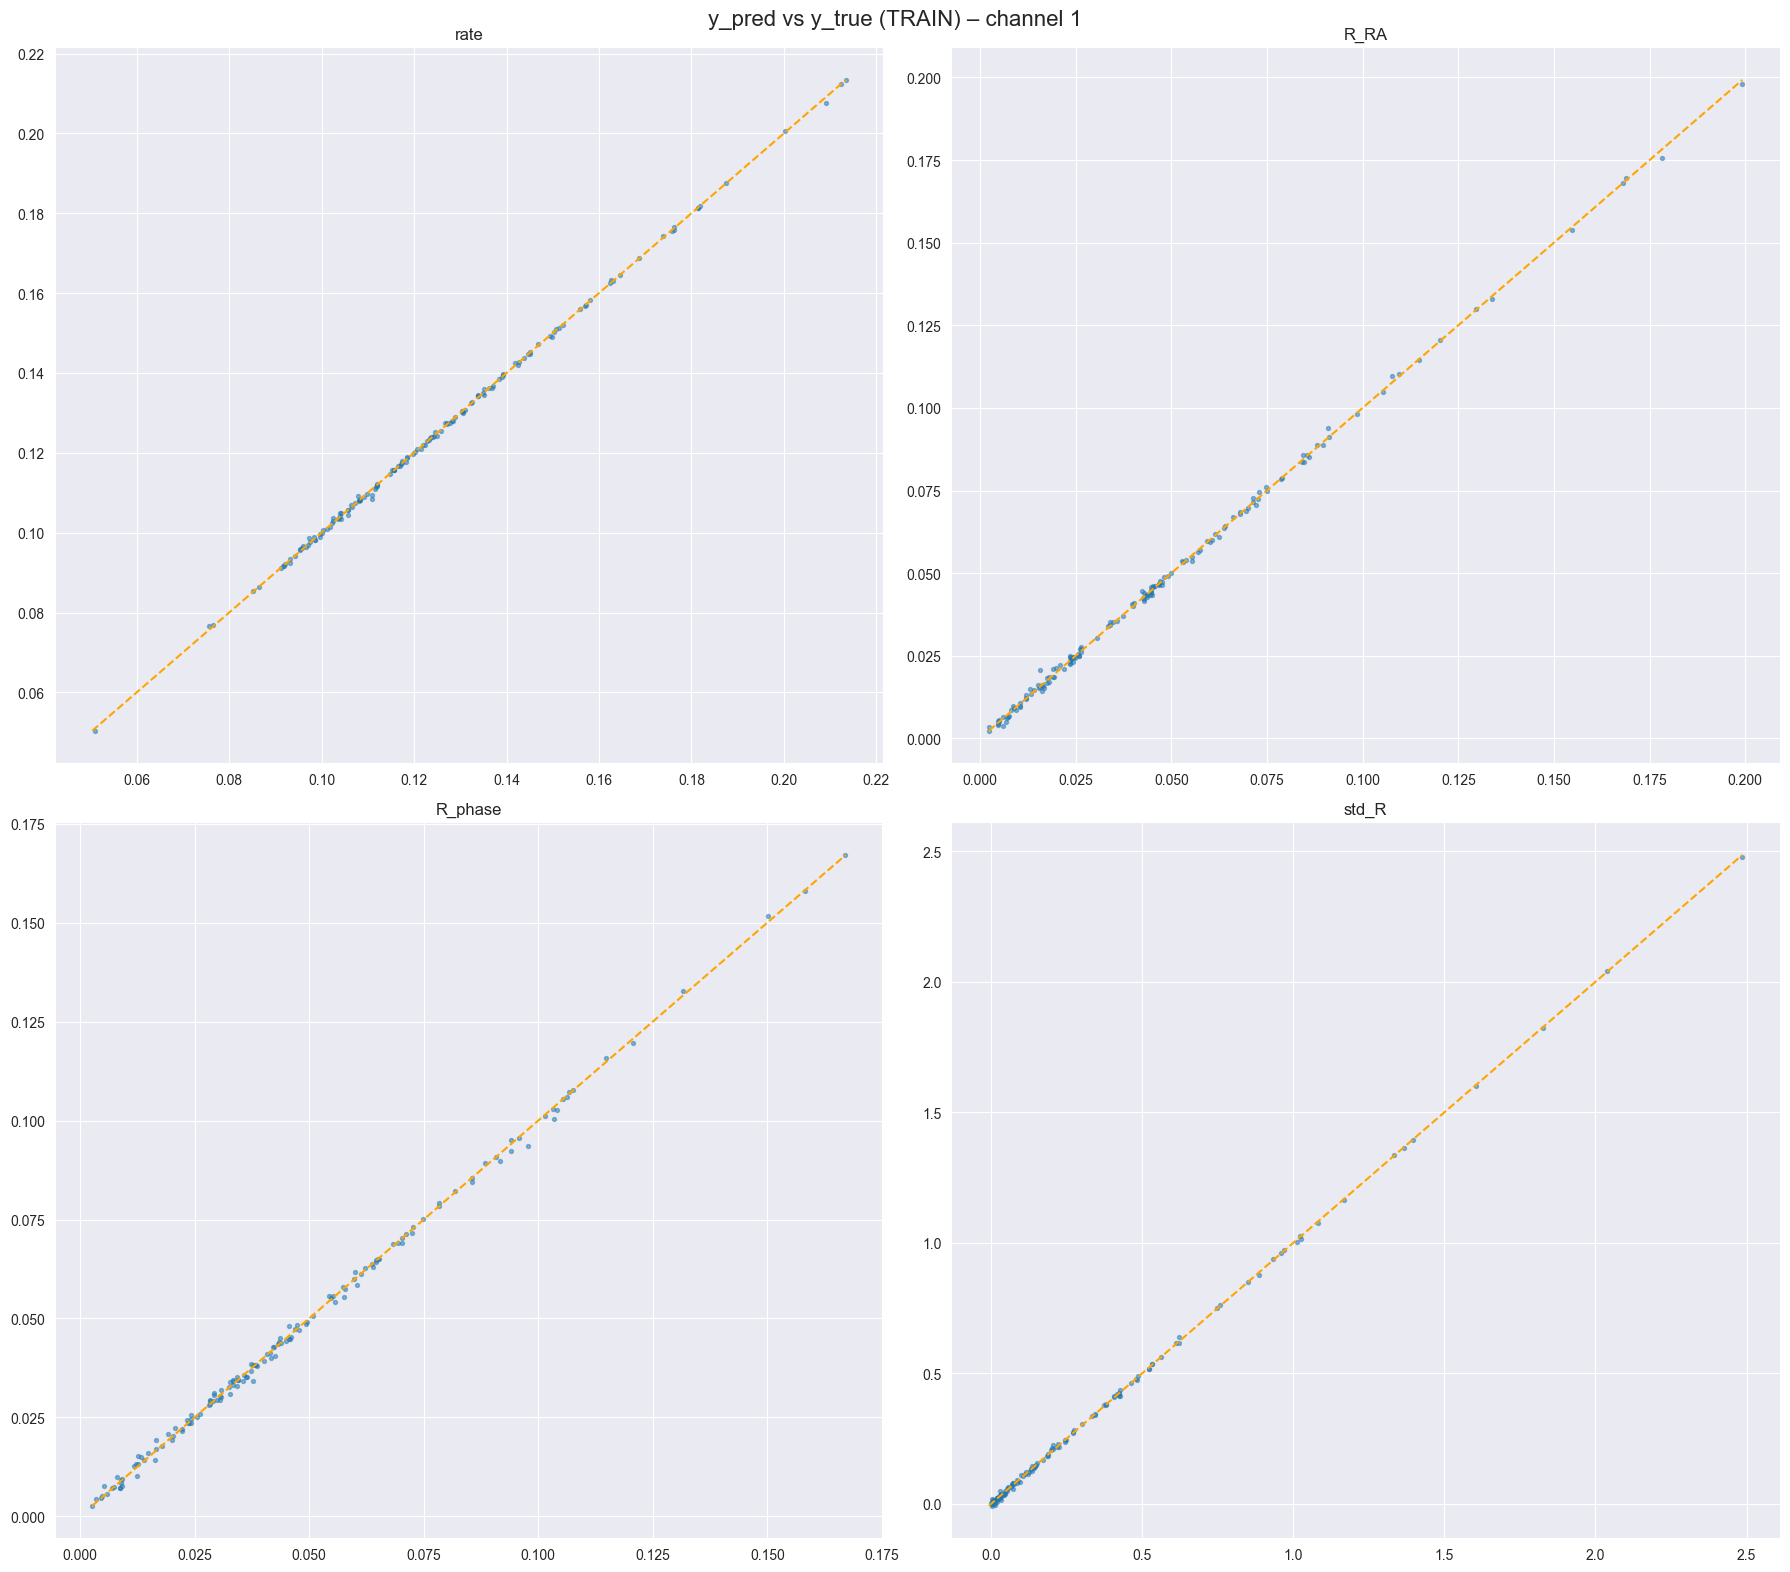

In [76]:
# CONFIG
DATA_DIR = "channel_analyzer_out_aggregated/AfterPerigeeChange"
TARGET_CHANNEL = 1

FEATURE_IDXS = [
    # 0,      # sum
    4,      # rate
    # 5,      # cos(RA)
    # 6,      # sin(RA)
    7,      # R_RA
    # 8,    # cos(phase)
    # 9,    # sin(phase)
    10,   # R(phase)
    # 11,   # mean(X)
    # 12,   # mean(Y)
    # 13,   # mean(Z)
    # 14,   # std(X)
    # 15,   # std(Y)
    # 16,   # std(Z)
    # 17,   # mean(R)
    18    # std(R)
]
FEATURE_NAMES = [
    # "sum",
    "rate",
    # "cos_RA",
    # "sin_RA",
    "R_RA",
    # "cos_phase",
    # "sin_phase",
    "R_phase",
    # "mean_X",
    # "mean_Y",
    # "mean_Z",
    # "std_X",
    # "std_Y",
    # "std_Z",
    # "mean_R",
    "std_R"
]
# LOAD DATA
channel_data = {}
lengths = []

for ch in range(1, 15):
    path = os.path.join(DATA_DIR, f"channel_{ch}_good_data_aggregated.txt")
    data = np.loadtxt(path, skiprows=1)
    channel_data[ch] = data
    lengths.append(len(data))

min_len = min(lengths)
print("Using common length:", min_len)

# BUILD X, y
X_list = []
y_list = []

for i in range(min_len):
    x_row = []

    for ch in range(1, 15):
        features = channel_data[ch][i, FEATURE_IDXS]

        if ch == TARGET_CHANNEL:
            y_row = features
        else:
            x_row.extend(features)

    X_list.append(x_row)
    y_list.append(y_row)

X = np.array(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y shape:", y.shape)

# SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SCALE
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test  = scaler_y.transform(y_test)
# MODEL
mlp = MLPRegressor(
    hidden_layer_sizes=(32, ),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    max_iter=3000,
    random_state=42,
    tol=1e-6
)

mlp.fit(X_train, y_train)
# PREDICTION
y_train_pred = mlp.predict(X_train)
y_test_pred  = mlp.predict(X_test)

# METRICS (global)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
# INVERSE SCALE (y)
y_train_true_phys = scaler_y.inverse_transform(y_train)
y_train_pred_phys = scaler_y.inverse_transform(y_train_pred)
y_test_true_phys  = scaler_y.inverse_transform(y_test)
y_test_pred_phys  = scaler_y.inverse_transform(y_test_pred)
rmse_phys = np.sqrt(mean_squared_error(y_test_true_phys, y_test_pred_phys))
mae_phys  = mean_absolute_error(y_test_true_phys, y_test_pred_phys)
rmse_phys_train = np.sqrt(mean_squared_error(y_train_true_phys, y_train_pred_phys))
mae_phys_train  = mean_absolute_error(y_train_true_phys, y_train_pred_phys)
std_train = np.std(y_train)
std_test  = np.std(y_test)
rmse_std_train = rmse_train / std_train
rmse_std_test  = rmse / std_test
std_train_phys = np.std(y_train_true_phys)
std_test_phys  = np.std(y_test_true_phys)
rmse_std_train_phys = rmse_phys_train / std_train_phys
rmse_std_test_phys  = rmse_phys / std_test_phys

print("==== TRAINING ====")
print(f"RMSE (global):        {rmse_train:.4f}")
print(f"MAE  (global):        {mae_train:.4f}")
print(f"STD  (global):        {std_train:.4f}")
print(f"RMSE / STD (global):  {rmse_std_train:.4f}")

print(f"RMSE (physical):      {rmse_phys_train:.4f}")
print(f"MAE  (physical):      {mae_phys_train:.4f}")
print(f"STD  (physical):      {std_train_phys:.4f}")
print(f"RMSE / STD (physical):{rmse_std_train_phys:.4f}")

print("\n==== TEST ====")
print(f"TARGET CHANNEL = {TARGET_CHANNEL}")

print(f"RMSE (global):        {rmse:.4f}")
print(f"MAE  (global):        {mae:.4f}")
print(f"STD  (global):        {std_test:.4f}")
print(f"RMSE / STD (global):  {rmse_std_test:.4f}")

print(f"RMSE (physical):      {rmse_phys:.4f}")
print(f"MAE  (physical):      {mae_phys:.4f}")
print(f"STD  (physical):      {std_test_phys:.4f}")
print(f"RMSE / STD (physical):{rmse_std_test_phys:.4f}")


# PLOTS


#y_pred vs y_true (TEST)
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
    ax.scatter(
        y_test_true_phys[:, i],
        y_test_pred_phys[:, i],
        s=8,
        alpha=0.5
    )
    lims = [
        min(y_test_true_phys[:, i].min(), y_test_pred_phys[:, i].min()),
        max(y_test_true_phys[:, i].max(), y_test_pred_phys[:, i].max())
    ]
    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(FEATURE_NAMES[i])
    ax.grid(True)

plt.suptitle(f"y_pred vs y_true (TEST) – channel {TARGET_CHANNEL}", fontsize=16)
plt.tight_layout()
plt.show()

# Training loss plot
plt.figure(figsize=(10, 5))
plt.plot(mlp.loss_curve_, label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MLP training loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(FEATURE_NAMES)]):
    ax.scatter(
        y_train_true_phys[:, i],
        y_train_pred_phys[:, i],
        s=8,
        alpha=0.5
    )

    lims = [
        min(y_train_true_phys[:, i].min(), y_train_pred_phys[:, i].min()),
        max(y_train_true_phys[:, i].max(), y_train_pred_phys[:, i].max())
    ]

    ax.plot(lims, lims, "--", color="orange")
    ax.set_title(FEATURE_NAMES[i])
    ax.grid(True)

plt.suptitle(
    f"y_pred vs y_true (TRAIN) – channel {TARGET_CHANNEL}",
    fontsize=16
)
plt.tight_layout()
plt.show()

In [29]:
from graphviz import Digraph

real_layers = [208, 64, 32, 16]
stride = [16, 16, 16, 16]

layer_names = [
    "Input layer\n(208 features)",
    "Hidden layer 1\n(64 neurons)\nReLU",
    "Hidden layer 2\n(32 neurons)\nReLU",
    "Output layer\n(16 features)\nLinear"
]

dot = Digraph(
    format="pdf",
    graph_attr={
        "rankdir": "LR",
        "splines": "true",
        "nodesep": "0.5",
        "ranksep": "4.5",
        "size": "16,9!",
        "margin": "0.2"
    }
)

layers = []

for i, (real, step, name) in enumerate(zip(real_layers, stride, layer_names)):
    visible = list(range(0, real, step))
    layers.append(visible)

    with dot.subgraph(name=f"cluster_{i}") as c:
        c.attr(
            label=name,
            fontsize="24",
            fontname="Helvetica"
        )

        for n in visible:
            c.node(
                f"L{i}_N{n}",
                shape="circle",
                width="0.8",
                fixedsize="true",
                style="filled",
                fillcolor="white"
            )

for i in range(len(layers) - 1):
    for a in layers[i]:
        for b in layers[i + 1]:
            dot.edge(
                f"L{i}_N{a}",
                f"L{i+1}_N{b}",
                penwidth="0.4",
                color="black"
            )

dot.render("mlp_structure_final", view=True)


'mlp_structure_final.pdf'

In [2]:
import torch
from torchviz import make_dot
from IBEX_Module.IBEX_NN import RateAutoencoder

model = RateAutoencoder(input_dim=14, latent_dim=4)
x = torch.randn(1, 14)
x_hat, z = model(x)

dot = make_dot(
    x_hat,
    params=dict(model.named_parameters())
)

dot.render("rate_autoencoder_graph", format="pdf")

'rate_autoencoder_graph.pdf'